학습은 kaggle에 미리 받아놓은 데이터셋을 다운로드 받아서 colab에서 진행했습니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("geon05/dataset2")
path2 = kagglehub.dataset_download("geon05/damages-masks")

print("Path to dataset files:", path)
print("Path to dataset files:", path2)

100%|██████████| 17.7G/17.7G [14:53<00:00, 21.3MB/s]

Extracting files...


100%|██████████| 13.9G/13.9G [12:04<00:00, 20.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/geon05/dataset2/versions/1
Path to dataset files: /root/.cache/kagglehub/datasets/geon05/damages-masks/versions/1


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 200MB/s]


체크포인트 /content/drive/MyDrive/Colab Notebooks/last/damage_model03/2024010302/checkpoint_epoch24.pth 를 발견했습니다. 이어서 학습을 진행합니다.


<ipython-input-3-adca7d2e8ea0>:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


이전 에폭: 24 / best_val_loss: 0.0114


Epoch [26/50]: 100%|██████████| 7894/7894 [1:12:46<00:00,  1.81it/s]

Epoch [26/50] - G Loss: 2.7458, D Loss: 0.6389


Validation L1 Loss: 0.0104


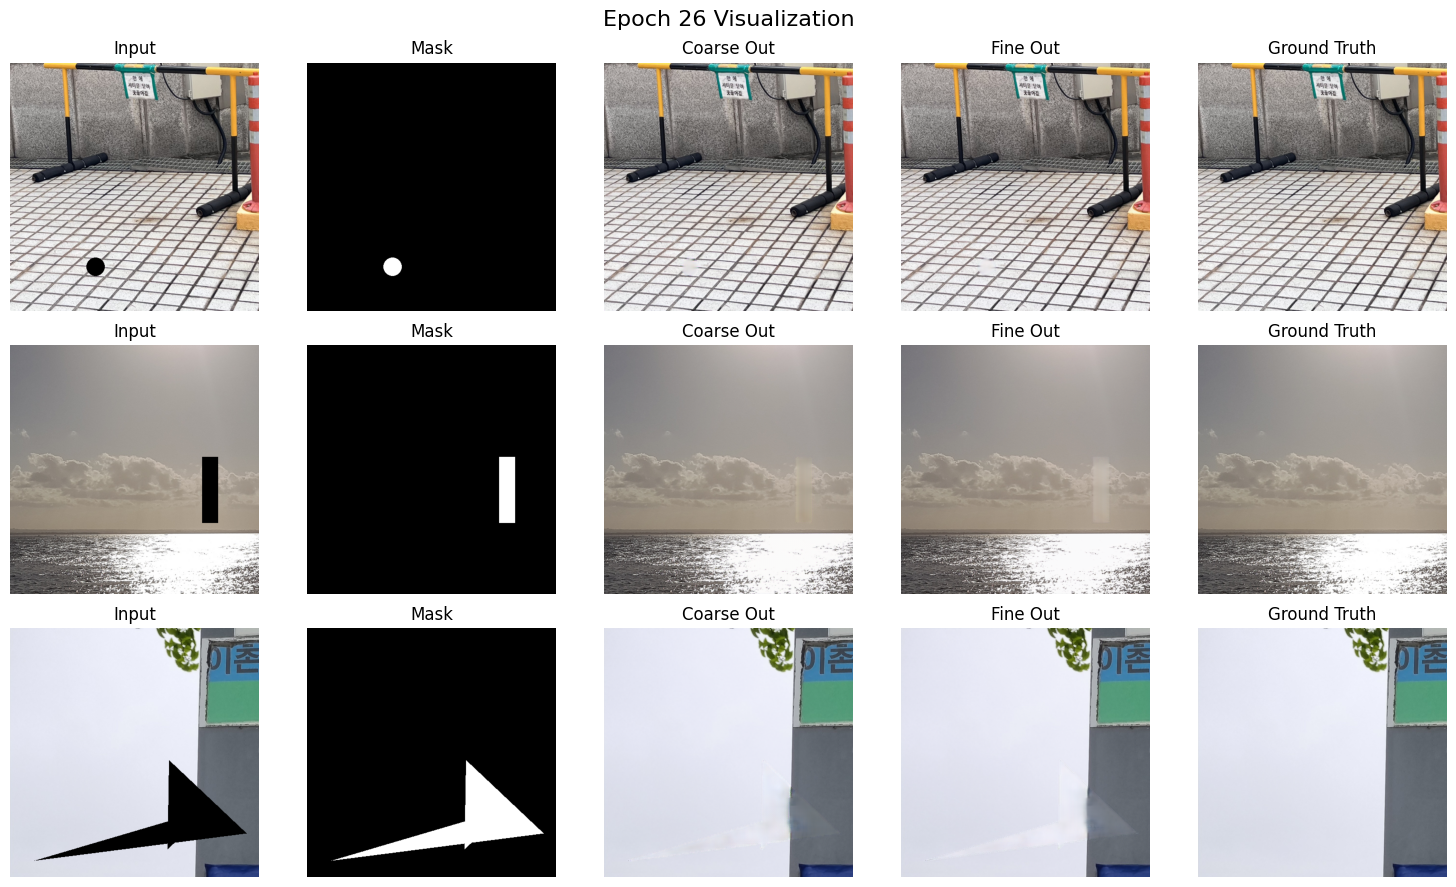

최적 모델 갱신! Validation L1 Loss: 0.0104, 모델 저장 완료.


Epoch [27/50]: 100%|██████████| 7894/7894 [1:12:52<00:00,  1.81it/s]

Epoch [27/50] - G Loss: 2.7097, D Loss: 0.6411


Validation L1 Loss: 0.0131


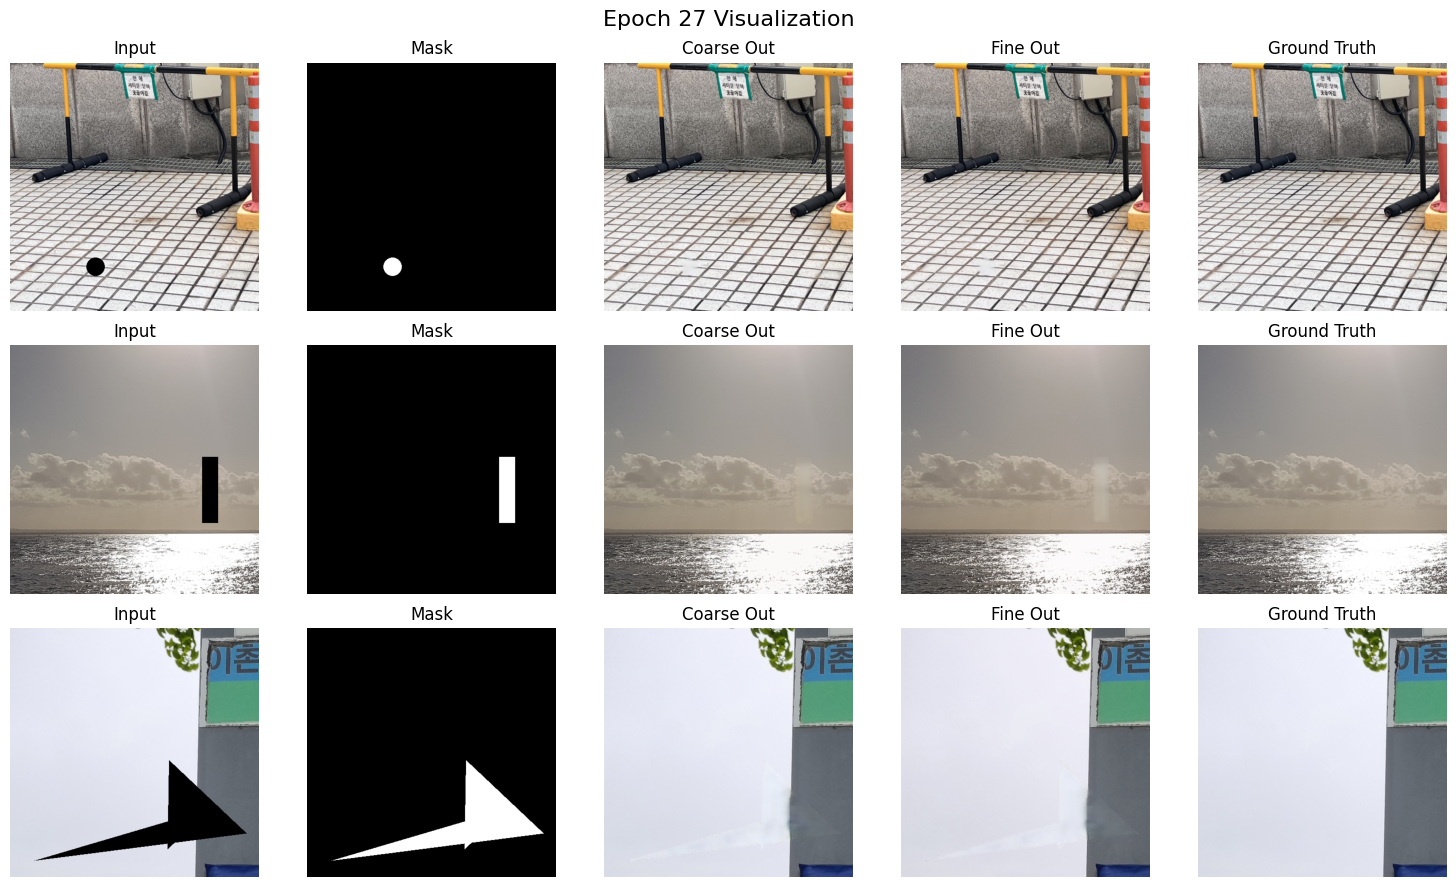

Epoch [28/50]: 100%|██████████| 7894/7894 [1:12:44<00:00,  1.81it/s]

Epoch [28/50] - G Loss: 2.6587, D Loss: 0.6478


Validation L1 Loss: 0.0099


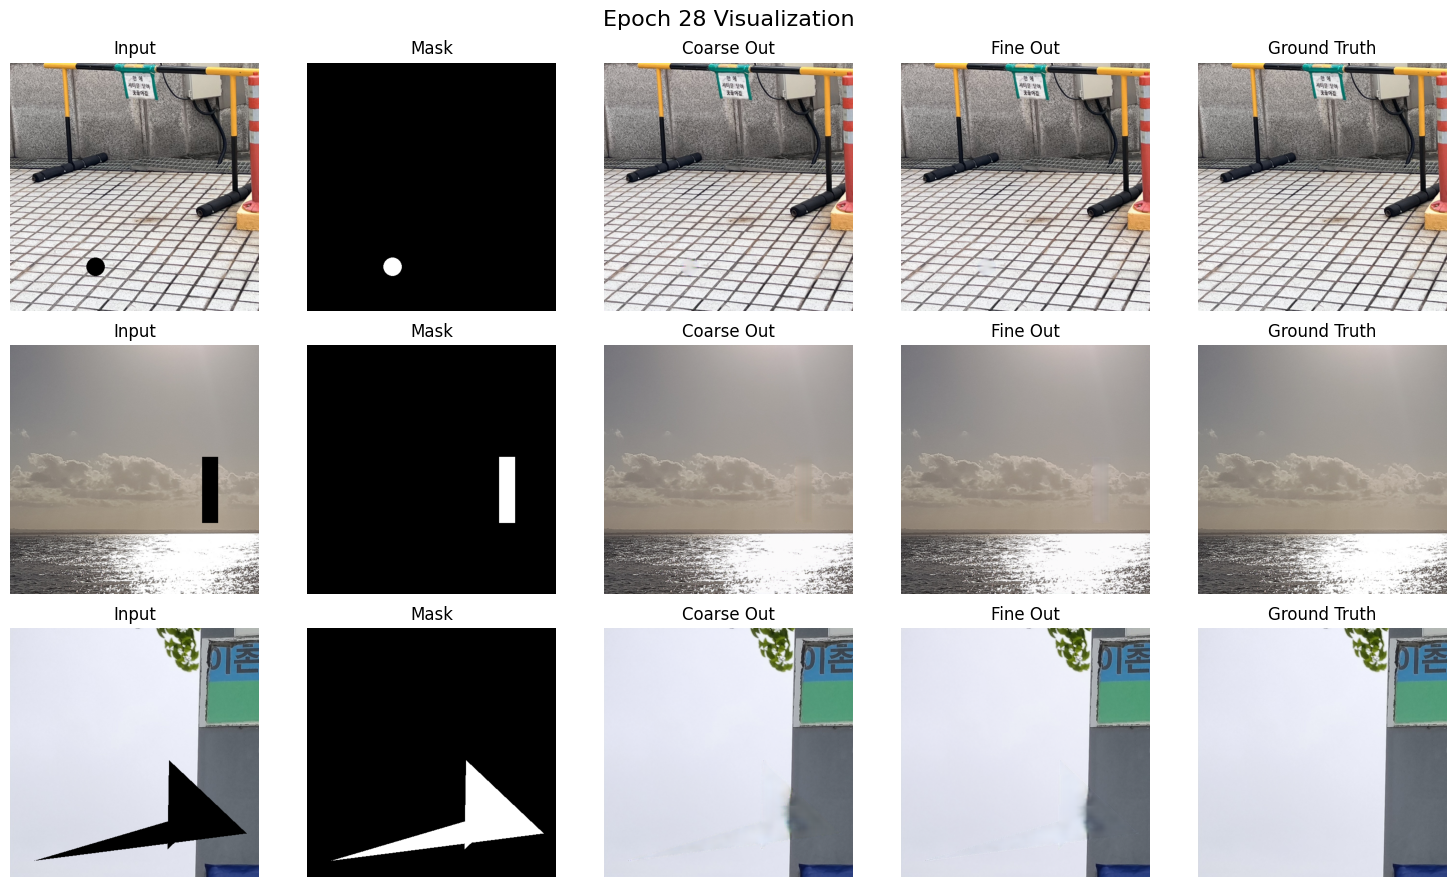

최적 모델 갱신! Validation L1 Loss: 0.0099, 모델 저장 완료.


Epoch [29/50]: 100%|██████████| 7894/7894 [1:12:40<00:00,  1.81it/s]

Epoch [29/50] - G Loss: 2.6095, D Loss: 0.6532


Validation L1 Loss: 0.0117


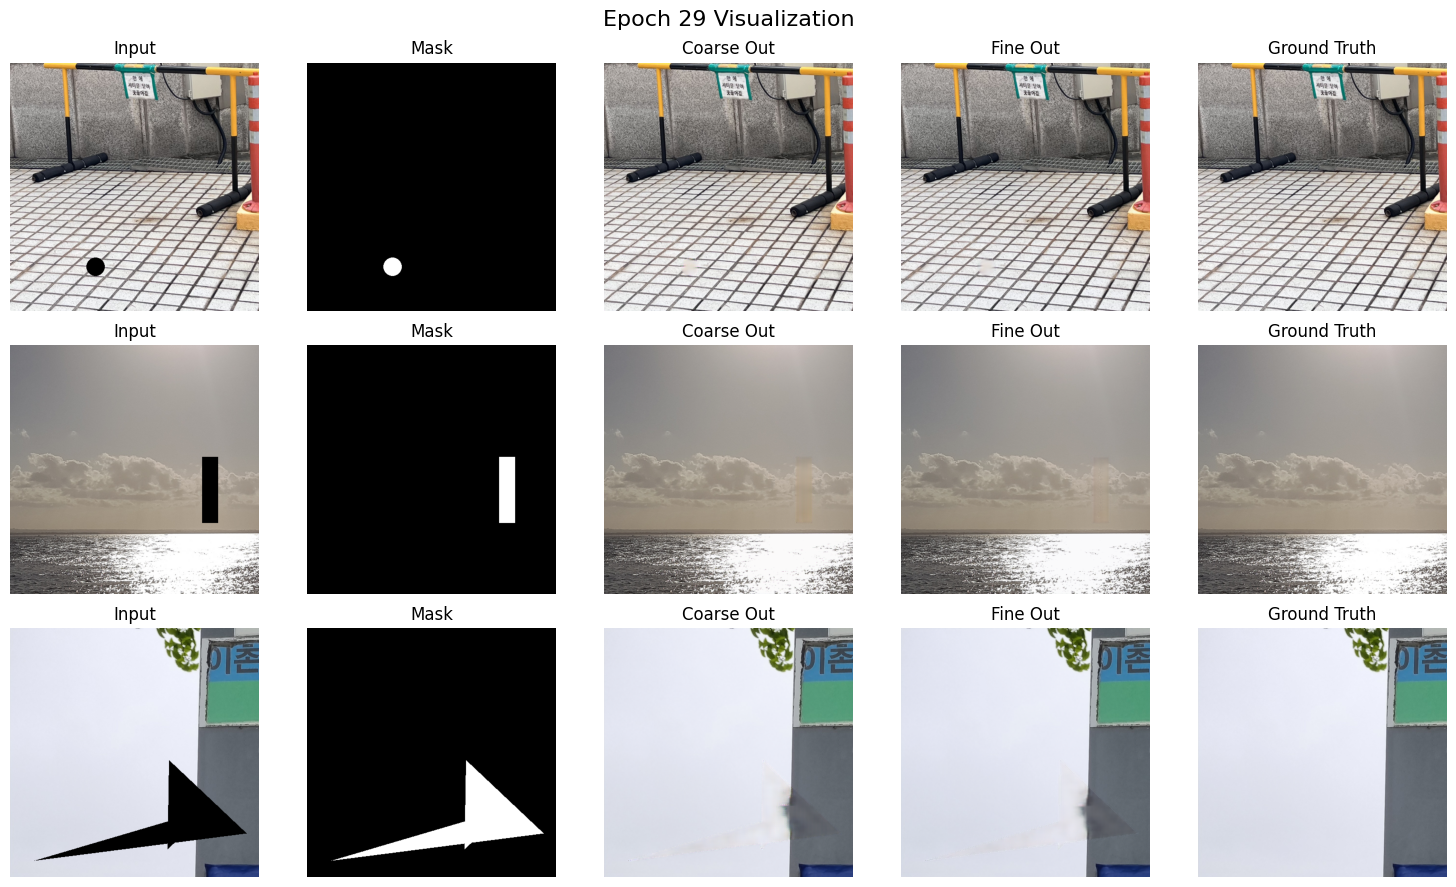

Epoch [30/50]: 100%|██████████| 7894/7894 [1:12:38<00:00,  1.81it/s]

Epoch [30/50] - G Loss: 2.5865, D Loss: 0.6530


Validation L1 Loss: 0.0101


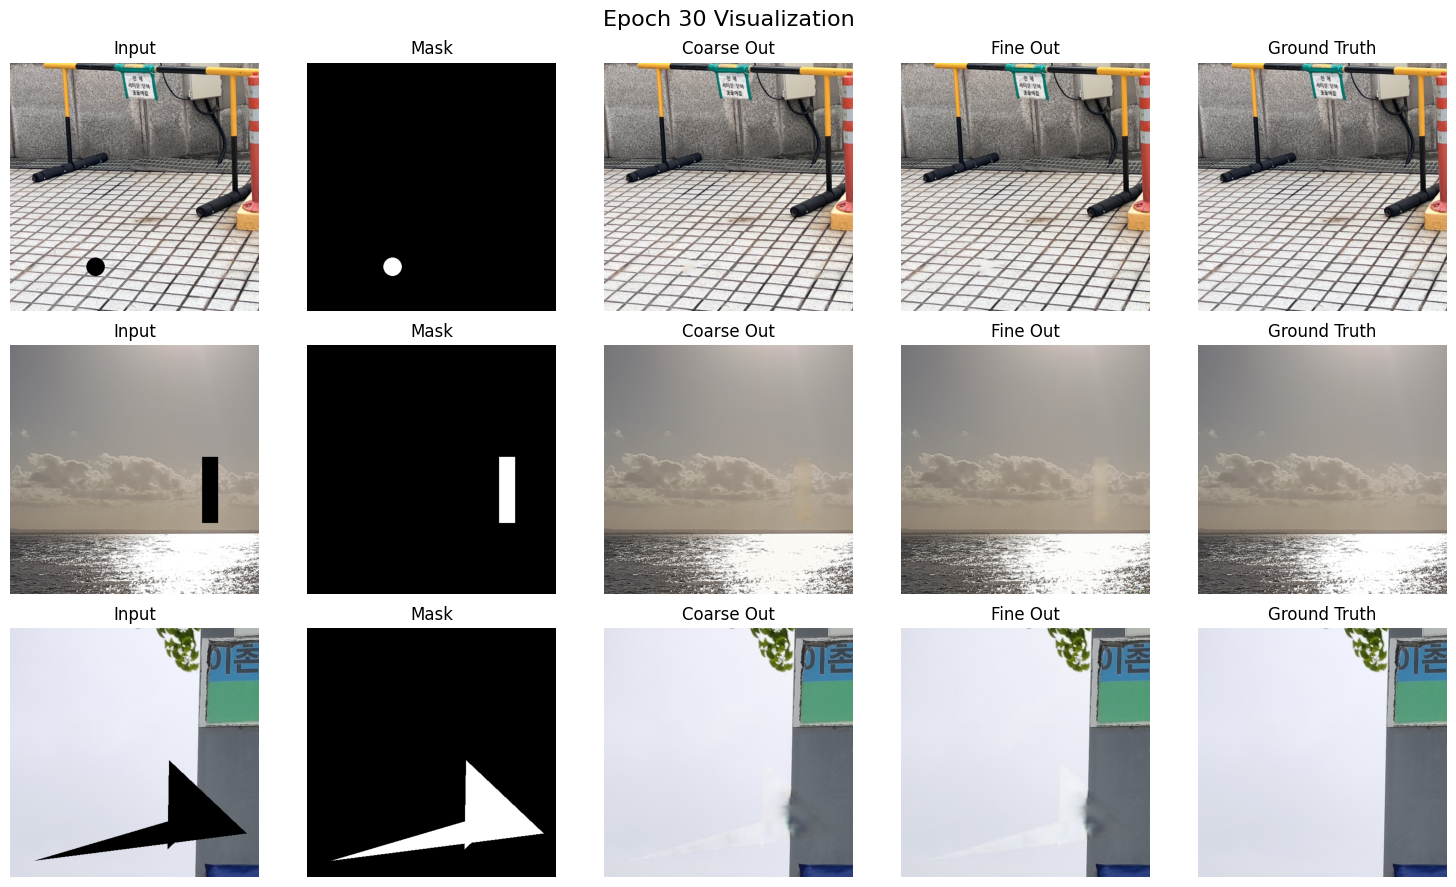

Epoch [31/50]: 100%|██████████| 7894/7894 [1:12:41<00:00,  1.81it/s]

Epoch [31/50] - G Loss: 2.5499, D Loss: 0.6568


Validation L1 Loss: 0.0100


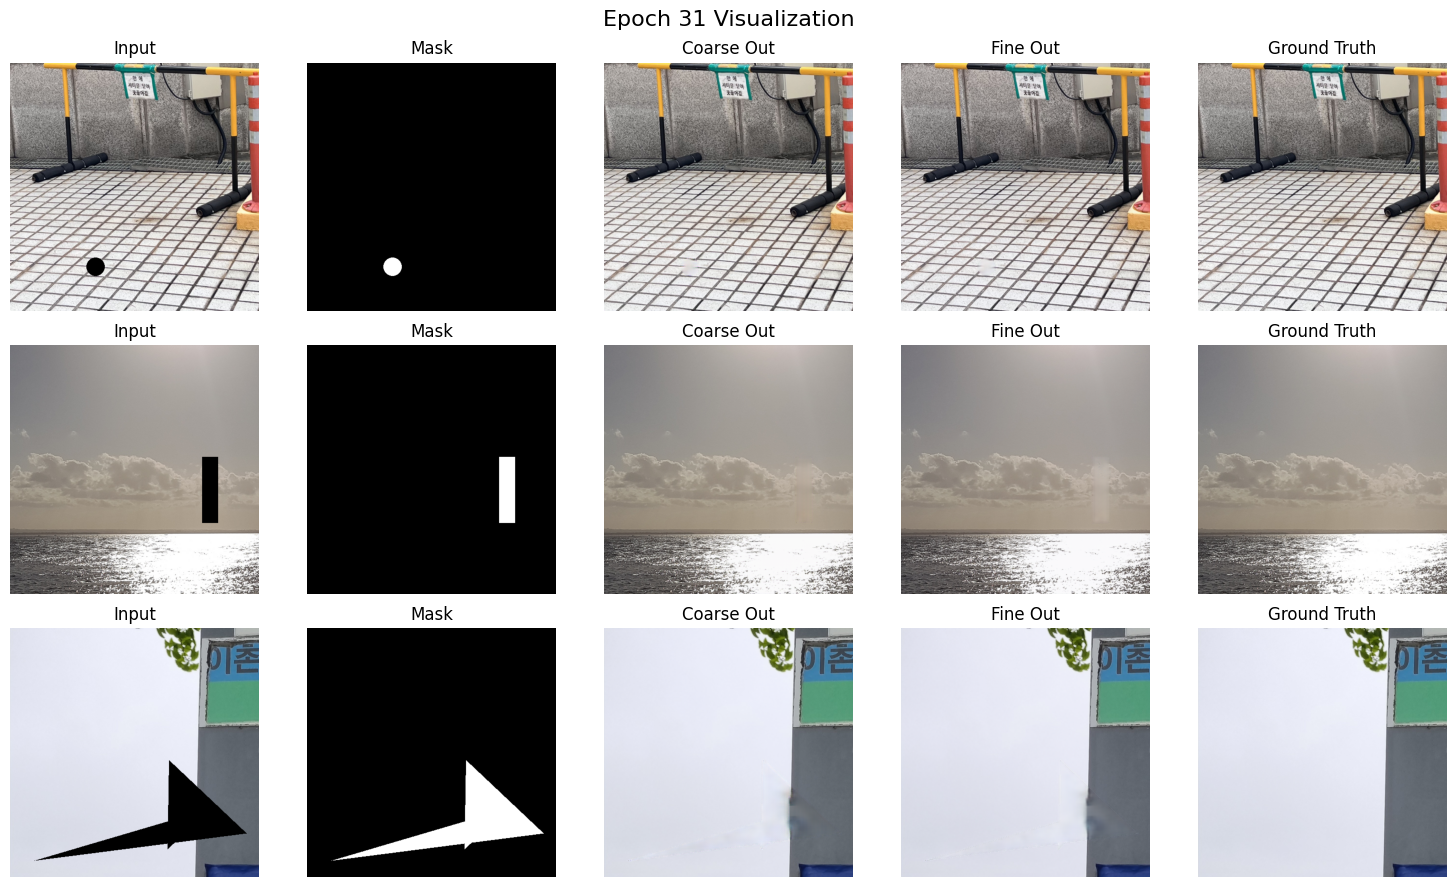

Epoch [32/50]: 100%|██████████| 7894/7894 [1:12:41<00:00,  1.81it/s]

Epoch [32/50] - G Loss: 2.5271, D Loss: 0.6571


Validation L1 Loss: 0.0123


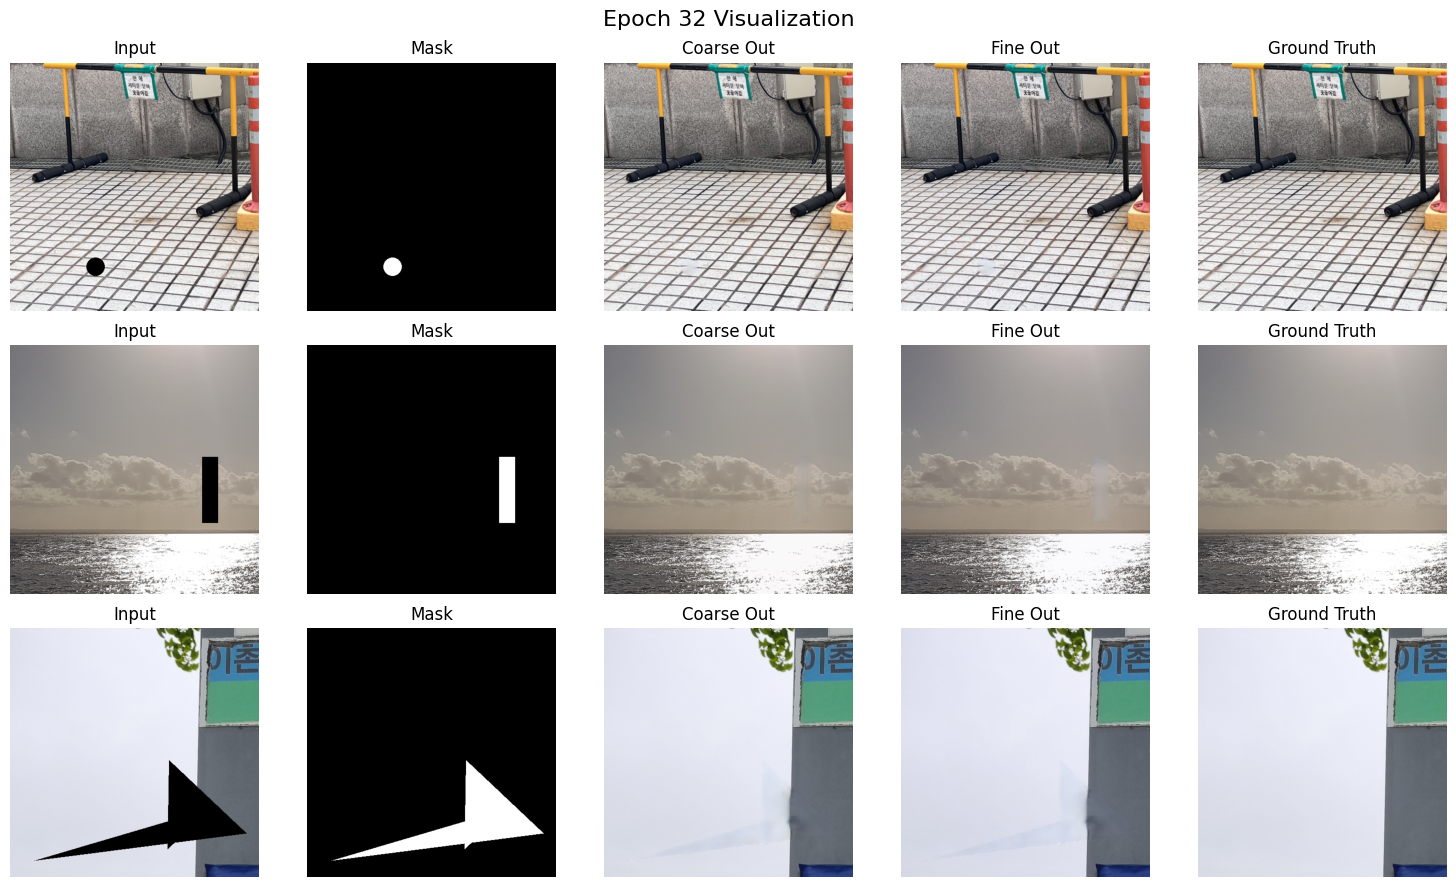

Epoch [33/50]: 100%|██████████| 7894/7894 [1:12:41<00:00,  1.81it/s]

Epoch [33/50] - G Loss: 2.5097, D Loss: 0.6578


Validation L1 Loss: 0.0099


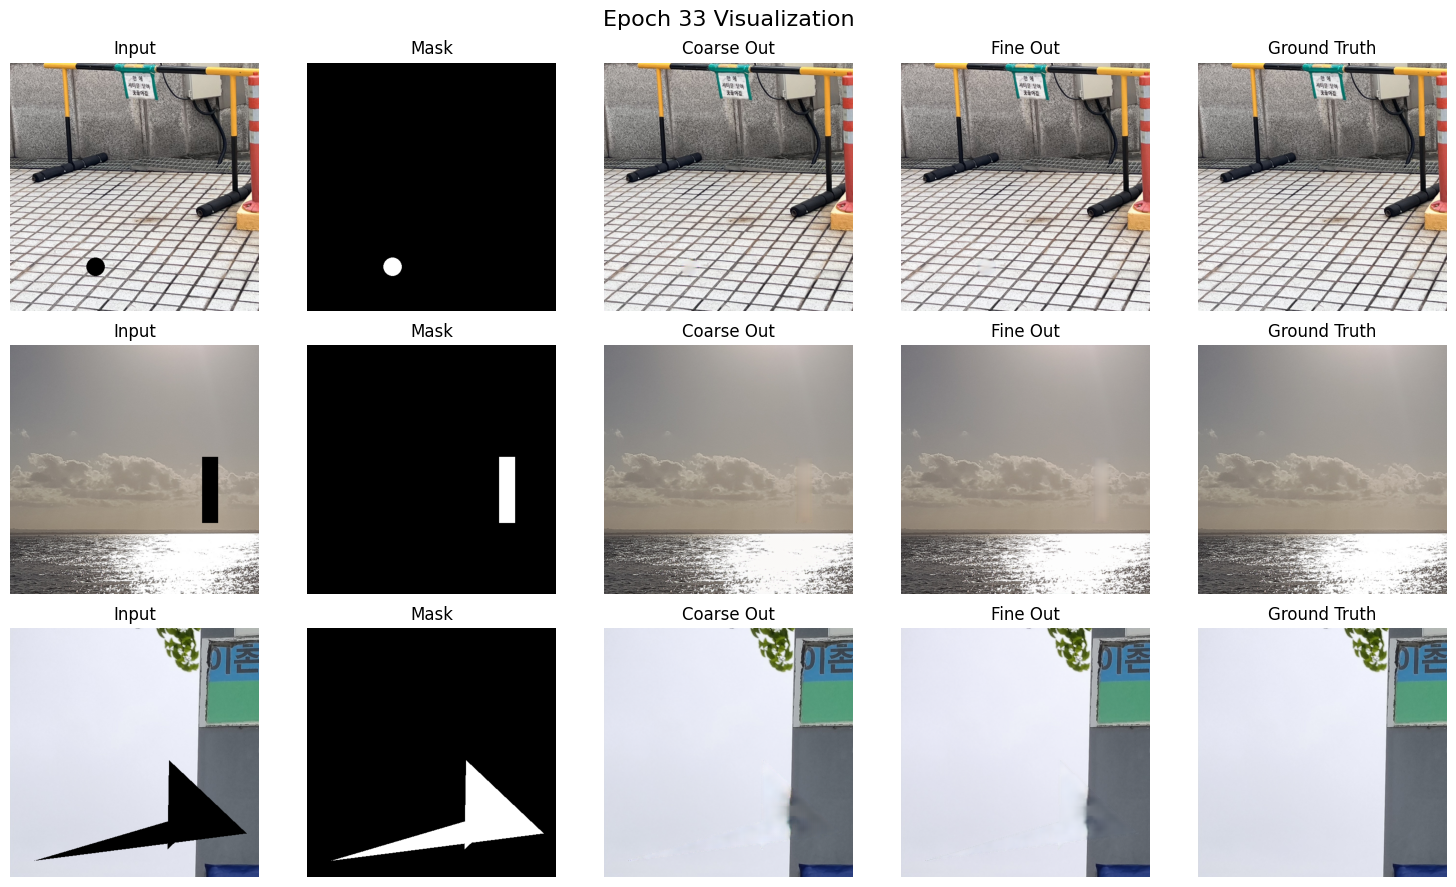

Epoch [34/50]:   6%|▌         | 468/7894 [04:18<1:08:21,  1.81it/s]

In [ ]:
import os
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from torchvision.models import vgg19, VGG19_Weights

#---------------------------
# 파라미터 설정
#---------------------------
batch_size = 3
lr = 0.0002
epochs = 50
test_size = 0.2
num_workers = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dir = "/root/.cache/kagglehub/datasets/geon05/damages-masks/versions/1/damage_images/damage_images"
gt_dir = "/root/.cache/kagglehub/datasets/geon05/dataset2/versions/1/train_gt"
mask_dir = "/root/.cache/kagglehub/datasets/geon05/damages-masks/versions/1/output_masks/output_masks"

save_dir = "/content/drive/MyDrive/Colab Notebooks/last/damage_model03/2025010401"
os.makedirs(save_dir, exist_ok=True)

checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/last/damage_model03/2024010302/checkpoint_epoch24.pth"

#---------------------------
# Perceptual Loss 정의
#---------------------------
class VGGPerceptualLoss(nn.Module):
    def __init__(self, layer_ids=[0, 5, 10, 19, 28], requires_grad=False):
        super(VGGPerceptualLoss, self).__init__()
        vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
        self.layers = nn.ModuleList([vgg[i] for i in layer_ids])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x, y):
        loss = 0.0
        for layer in self.layers:
            x = layer(x)
            y = layer(y)
            loss += nn.functional.l1_loss(x, y)
        return loss

vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)

def normalize_vgg_inputs(img):
    return (img - vgg_mean) / vgg_std

#---------------------------
# Gated Convolution Layer 정의
#---------------------------
class GatedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, activation=nn.ReLU()):
        super(GatedConv2d, self).__init__()
        self.feature_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.mask_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.sigmoid = nn.Sigmoid()
        self.activation = activation

    def forward(self, x):
        f = self.feature_conv(x)
        m = self.mask_conv(x)
        gated = self.sigmoid(m)
        if self.activation is not None:
            f = self.activation(f)
        return f * gated

class GatedDeconv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, activation=nn.ReLU()):
        super(GatedDeconv2d, self).__init__()
        self.feature_deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.mask_deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.sigmoid = nn.Sigmoid()
        self.activation = activation

    def forward(self, x):
        f = self.feature_deconv(x)
        m = self.mask_deconv(x)
        gated = self.sigmoid(m)
        if self.activation is not None:
            f = self.activation(f)
        return f * gated

class ContextualAttention(nn.Module):
    def __init__(self, kernel_size=3, stride=1, dilation=1):
        super(ContextualAttention, self).__init__()
        self.conv = nn.Conv2d(512, 512, kernel_size, stride, dilation, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        B,C,H,W = x.size()
        query = x.view(B,C,-1)
        key = x.view(B,C,-1)
        value = x.view(B,C,-1)

        attn = torch.bmm(query.permute(0,2,1), key)
        attn = self.softmax(attn)
        out = torch.bmm(attn, value.permute(0,2,1))
        out = out.permute(0,2,1).view(B,C,H,W)
        out = self.conv(out)
        return out

class Stage1Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # ----- Encoder (Down) -----
        self.enc1 = GatedConv2d(4, 64, 4, 2, 1)
        self.enc2 = GatedConv2d(64, 128, 4, 2, 1)
        self.enc3 = GatedConv2d(128, 256, 4, 2, 1)
        self.enc4 = GatedConv2d(256, 512, 4, 2, 1)

        # ----- Decoder (Up) -----
        # 1) e4 -> d1, (H/16 -> H/8)
        #    cat with e3 → (256 + 256) -> dec1_2
        self.dec1_up = GatedDeconv2d(512, 256, 4, 2, 1)
        self.dec1_conv = GatedConv2d(256 + 256, 256, 3, 1, 1)

        # 2) d1 -> d2, (H/8 -> H/4)
        #    cat with e2 → (256 + 128) -> dec2_2
        self.dec2_up = GatedDeconv2d(256, 128, 4, 2, 1)
        self.dec2_conv = GatedConv2d(128 + 128, 128, 3, 1, 1)

        # 3) d2 -> d3, (H/4 -> H/2)
        #    cat with e1 → (128 + 64) -> dec3_2
        self.dec3_up = GatedDeconv2d(128, 64, 4, 2, 1)
        self.dec3_conv = GatedConv2d(64 + 64, 64, 3, 1, 1)

        # 4) d3 -> d4, (H/2 -> H)
        #    여기서는 skip이 inp(4ch)일 수도, e0(3ch+mask)일 수도 있지만 보통 e1까지만.
        self.dec4_up = GatedDeconv2d(64, 64, 4, 2, 1)
        self.dec4_conv = nn.Conv2d(64, 3, 3, 1, 1)
        self.final_act = nn.Sigmoid()

    def forward(self, x, mask):
        # ----- Encoder -----
        inp = torch.cat((x, mask), dim=1)  # (N, 4, H, W)
        e1 = self.enc1(inp)    # (N,64,  H/2,  W/2)
        e2 = self.enc2(e1)     # (N,128, H/4,  W/4)
        e3 = self.enc3(e2)     # (N,256, H/8,  W/8)
        e4 = self.enc4(e3)     # (N,512, H/16, W/16)

        # ----- Decoder -----
        # 1) 업샘플 e4 -> d1_up (H/16 -> H/8), cat e3
        d1_up = self.dec1_up(e4)              # (N,256, H/8, W/8)
        d1_in = torch.cat([d1_up, e3], dim=1) # (N,256+256=512, H/8, W/8)
        d1 = self.dec1_conv(d1_in)           # (N,256, H/8, W/8)

        # 2) 업샘플 d1 -> d2_up (H/8 -> H/4), cat e2
        d2_up = self.dec2_up(d1)              # (N,128, H/4, W/4)
        d2_in = torch.cat([d2_up, e2], dim=1) # (N,128+128=256, H/4, W/4)
        d2 = self.dec2_conv(d2_in)           # (N,128, H/4, W/4)

        # 3) 업샘플 d2 -> d3_up (H/4 -> H/2), cat e1
        d3_up = self.dec3_up(d2)              # (N,64, H/2, W/2)
        d3_in = torch.cat([d3_up, e1], dim=1) # (N,64+64=128, H/2, W/2)
        d3 = self.dec3_conv(d3_in)           # (N,64, H/2, W/2)

        # 4) 업샘플 d3 -> d4_up (H/2 -> H)
        d4_up = self.dec4_up(d3)             # (N,64, H, W)
        d4 = self.dec4_conv(d4_up)           # (N,3,  H, W)

        out = self.final_act(d4)
        return out



class Stage2Generator(nn.Module):
    def __init__(self):
        super(Stage2Generator, self).__init__()

        # ------------------------
        # Encoder
        # ------------------------
        self.enc1 = GatedConv2d(7,   64, 4, 2, 1)  # (N, 64,  H/2,  W/2)
        self.enc2 = GatedConv2d(64,  128, 4, 2, 1) # (N, 128, H/4,  W/4)
        self.enc3 = GatedConv2d(128, 256, 4, 2, 1) # (N, 256, H/8,  W/8)
        self.enc4 = GatedConv2d(256, 512, 4, 2, 1) # (N, 512, H/16, W/16)

        # Contextual Attention (옵션)
        self.contextual_attention = ContextualAttention()

        # ------------------------
        # Decoder (U-Net style)
        #   - dec1_up: e4(H/16→H/8)
        #   - dec1_conv: concat with e3 → (256+256)
        #   - dec2_up: d1(H/8→H/4)
        #   - dec2_conv: concat with e2 → (128+128)
        #   - ...
        # ------------------------

        # 1) H/16 -> H/8
        self.dec1_up   = GatedDeconv2d(512, 256, 4, 2, 1)
        self.dec1_conv = GatedConv2d(256 + 256, 256, 3, 1, 1)

        # 2) H/8 -> H/4
        self.dec2_up   = GatedDeconv2d(256, 128, 4, 2, 1)
        self.dec2_conv = GatedConv2d(128 + 128, 128, 3, 1, 1)

        # 3) H/4 -> H/2
        self.dec3_up   = GatedDeconv2d(128, 64, 4, 2, 1)
        self.dec3_conv = GatedConv2d(64 + 64, 64, 3, 1, 1)

        # 4) H/2 -> H
        self.dec4_up   = GatedDeconv2d(64, 64, 4, 2, 1)
        self.dec4_conv = nn.Conv2d(64, 3, 3, 1, 1)

        self.final_act = nn.Sigmoid()

    def forward(self, coarse_out, inp, mask):
        # (N, 3, H, W), (N,3,H,W), (N,1,H,W)
        fin_inp = torch.cat((coarse_out, inp, mask), dim=1) # (N,7,H,W)

        # ----- Encoder -----
        e1 = self.enc1(fin_inp)  # (N,64,  H/2,  W/2)
        e2 = self.enc2(e1)       # (N,128, H/4,  W/4)
        e3 = self.enc3(e2)       # (N,256, H/8,  W/8)
        e4 = self.enc4(e3)       # (N,512, H/16, W/16)

        # Contextual Attention (옵션)
        e4_attn = self.contextual_attention(e4)  # (N,512, H/16, W/16)

        # ----- Decoder -----
        # 1) 업샘플 e4_attn -> d1_up(H/8), concat e3
        d1_up = self.dec1_up(e4_attn)            # (N,256, H/8, W/8)
        d1_in = torch.cat([d1_up, e3], dim=1)    # (N,256+256=512, H/8, W/8)
        d1 = self.dec1_conv(d1_in)              # (N,256, H/8, W/8)

        # 2) 업샘플 d1 -> d2_up(H/4), concat e2
        d2_up = self.dec2_up(d1)                 # (N,128, H/4, W/4)
        d2_in = torch.cat([d2_up, e2], dim=1)    # (N,128+128=256, H/4, W/4)
        d2 = self.dec2_conv(d2_in)              # (N,128, H/4, W/4)

        # 3) 업샘플 d2 -> d3_up(H/2), concat e1
        d3_up = self.dec3_up(d2)                 # (N,64,  H/2, W/2)
        d3_in = torch.cat([d3_up, e1], dim=1)    # (N,64+64=128, H/2, W/2)
        d3 = self.dec3_conv(d3_in)              # (N,64,  H/2, W/2)

        # 4) 업샘플 d3 -> d4_up(H), 최종
        d4_up = self.dec4_up(d3)                 # (N,64,  H, W)
        d4    = self.dec4_conv(d4_up)            # (N,3,   H, W)

        out = self.final_act(d4)
        return out



class GlobalDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(GlobalDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 1)  # 최종 출력: (N,1,H',W')
        )

    def forward(self, x):
        return self.model(x)

class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3, ndf=64):
        super(PatchDiscriminator, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(ndf, ndf*2, 4, 2, 1),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(ndf*4, ndf*8, 4, 1, 1),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.final = nn.Conv2d(ndf*8, 1, 4, 1, 1)

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.final(out)  # shape: (N,1,H',W')
        return out


class InpaintDataset(Dataset):
    def __init__(self, input_paths, gt_paths, mask_paths, transform=None):
        self.input_paths = input_paths
        self.gt_paths = gt_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        inp = Image.open(self.input_paths[idx]).convert("RGB")
        gt = Image.open(self.gt_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            inp = self.transform(inp)
            gt = self.transform(gt)
            mask = self.transform(mask)

        return inp, gt, mask

input_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(('png','jpg','jpeg'))])
gt_files = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir) if f.endswith(('png','jpg','jpeg'))])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('png','jpg','jpeg'))])

train_input_paths, val_input_paths, train_gt_paths, val_gt_paths, train_mask_paths, val_mask_paths = train_test_split(
    input_files, gt_files, mask_files, test_size=test_size, random_state=42)

transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor()
])

train_dataset = InpaintDataset(train_input_paths, train_gt_paths, train_mask_paths, transform=transform)
val_dataset = InpaintDataset(val_input_paths, val_gt_paths, val_mask_paths, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# 모델 초기화
coarse_generator = Stage1Generator().to(device)
fine_generator = Stage2Generator().to(device)

# 멀티 스케일 Discriminator
D_global = GlobalDiscriminator(in_channels=3).to(device)
D_patch = PatchDiscriminator(in_channels=3, ndf=64).to(device)

# Optimizer
g_params = list(coarse_generator.parameters()) + list(fine_generator.parameters())
g_optimizer = optim.Adam(g_params, lr=0.0002, betas=(0.5, 0.9))

d_global_optimizer = optim.Adam(D_global.parameters(), lr=0.0002, betas=(0.5, 0.9))
d_patch_optimizer  = optim.Adam(D_patch.parameters(),  lr=0.0002, betas=(0.5, 0.9))

l1_loss = nn.L1Loss()
mse_loss = nn.MSELoss()
bce_loss = nn.BCEWithLogitsLoss()
perceptual_criterion = VGGPerceptualLoss().to(device)



best_val_loss = float('inf')

########################################
# 이전에 학습한 체크포인트 로드
########################################

start_epoch = 0  # 기본값: 0부터 시작

if os.path.exists(checkpoint_path):
    print(f"체크포인트 {checkpoint_path} 를 발견했습니다. 이어서 학습을 진행합니다.")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    coarse_generator.load_state_dict(checkpoint['coarse_generator'])
    fine_generator.load_state_dict(checkpoint['fine_generator'])
    D_global.load_state_dict(checkpoint['D_global'])
    D_patch.load_state_dict(checkpoint['D_patch'])

    g_optimizer.load_state_dict(checkpoint['g_optimizer'])
    d_global_optimizer.load_state_dict(checkpoint['d_global_optimizer'])
    d_patch_optimizer.load_state_dict(checkpoint['d_patch_optimizer'])

    best_val_loss = checkpoint['best_val_loss']
    start_epoch   = checkpoint['epoch'] + 1  # 이어서 학습할 에폭
    print(f"이전 에폭: {checkpoint['epoch']} / best_val_loss: {best_val_loss:.4f}")

else:
    print("체크포인트를 찾지 못했습니다. 처음부터 학습을 시작합니다.")
    start_epoch = 0
    best_val_loss = float('inf')

########################################
# 학습
########################################

for epoch in range(start_epoch, epochs):
    coarse_generator.train()
    fine_generator.train()
    D_global.train()
    D_patch.train()
    running_g_loss = 0.0
    running_d_loss = 0.0

    for i, (inp, gt, mask) in enumerate(tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")):
        inp, gt, mask = inp.to(device), gt.to(device), mask.to(device)

        # Coarse 단계
        coarse_out = coarse_generator(inp, mask)

        # Fine 단계
        fine_out = fine_generator(coarse_out, inp, mask)

        # Train Discriminator
        # ----- Global Discriminator -----
        real_pred_global = D_global(gt)
        fake_pred_global = D_global(fine_out.detach())

        real_label_global = torch.ones_like(real_pred_global).to(device)
        fake_label_global = torch.zeros_like(fake_pred_global).to(device)

        d_loss_real_g = bce_loss(real_pred_global, real_label_global)
        d_loss_fake_g = bce_loss(fake_pred_global, fake_label_global)
        d_loss_global = 0.5 * (d_loss_real_g + d_loss_fake_g)

        # ----- Patch Discriminator -----
        real_pred_patch = D_patch(gt)
        fake_pred_patch = D_patch(fine_out.detach())

        real_label_patch = torch.ones_like(real_pred_patch).to(device)
        fake_label_patch = torch.zeros_like(fake_pred_patch).to(device)

        d_loss_real_p = bce_loss(real_pred_patch, real_label_patch)
        d_loss_fake_p = bce_loss(fake_pred_patch, fake_label_patch)
        d_loss_patch = 0.5 * (d_loss_real_p + d_loss_fake_p)

        # 전체 D Loss
        d_loss = 0.5 * d_loss_global + 0.5 * d_loss_patch

        # Optimizer Step
        d_global_optimizer.zero_grad()
        d_patch_optimizer.zero_grad()

        d_loss.backward()

        d_global_optimizer.step()
        d_patch_optimizer.step()

        # Train Generator
        # GlobalD / PatchD에 다시 forward (detach 없이)
        fake_pred_global_g = D_global(fine_out)
        fake_pred_patch_g  = D_patch(fine_out)

        # Generator가 원하는 건 '전부 real로 분류'
        real_label_global_g = torch.ones_like(fake_pred_global_g, device=device)
        real_label_patch_g  = torch.ones_like(fake_pred_patch_g, device=device)

        g_adv_loss_global = bce_loss(fake_pred_global_g, real_label_global_g)
        g_adv_loss_patch  = bce_loss(fake_pred_patch_g, real_label_patch_g)

        # 가중 예시: 두 Adversarial 손실을 평균
        g_adv_loss = 0.5 * g_adv_loss_global + 0.5 * g_adv_loss_patch

        # Reconstruction Loss들 (coarse, fine)
        c_l1 = l1_loss(coarse_out, gt)
        c_mse = mse_loss(coarse_out, gt)
        c_perc = perceptual_criterion(normalize_vgg_inputs(coarse_out), normalize_vgg_inputs(gt))
        c_recon = 2.0 * c_l1 + 1.0 * c_mse + 1.0 * c_perc

        f_l1 = l1_loss(fine_out, gt)
        f_mse = mse_loss(fine_out, gt)
        f_perc = perceptual_criterion(normalize_vgg_inputs(fine_out), normalize_vgg_inputs(gt))
        f_recon = 2.0 * f_l1 + 1.0 * f_mse + 1.0 * f_perc

        # 최종 Generator Loss
        g_loss = 1.2 * g_adv_loss + 0.5 * c_recon + f_recon

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # 로그 누적
        running_g_loss += g_loss.item()
        running_d_loss += d_loss.item()

    avg_g_loss = running_g_loss / len(train_dataloader)
    avg_d_loss = running_d_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{epochs}] - G Loss: {avg_g_loss:.4f}, D Loss: {avg_d_loss:.4f}")

    # ---------------------------
    # Validation
    # ---------------------------
    coarse_generator.eval()
    fine_generator.eval()
    val_l1 = 0.0
    with torch.no_grad():
        for inp, gt, mask in val_dataloader:
            inp, gt, mask = inp.to(device), gt.to(device), mask.to(device)
            coarse_out = coarse_generator(inp, mask)
            fine_out = fine_generator(coarse_out, inp, mask)
            val_l1 += l1_loss(fine_out, gt).item()
    val_l1 = val_l1 / len(val_dataloader)
    print(f"Validation L1 Loss: {val_l1:.4f}")

    # ---------------------------
    # 에폭마다 시각화
    # ---------------------------
    with torch.no_grad():
        # (1) Validation dataloader에서 배치 하나 샘플 추출
        sample_inp, sample_gt, sample_mask = next(iter(val_dataloader))
        sample_inp, sample_gt, sample_mask = sample_inp.to(device), sample_gt.to(device), sample_mask.to(device)

        # (2) Generator 통과
        sample_coarse = coarse_generator(sample_inp, sample_mask)
        sample_fine = fine_generator(sample_coarse, sample_inp, sample_mask)

        # (3) Tensor -> NumPy (시각화를 위해 [N,C,H,W]->[N,H,W,C])
        sample_inp_np = sample_inp.detach().cpu().permute(0,2,3,1).numpy()
        sample_gt_np = sample_gt.detach().cpu().permute(0,2,3,1).numpy()
        sample_mask_np = sample_mask.detach().cpu().permute(0,2,3,1).numpy()
        sample_coarse_np = sample_coarse.detach().cpu().permute(0,2,3,1).numpy()
        sample_fine_np = sample_fine.detach().cpu().permute(0,2,3,1).numpy()

        # (4) 일부(batch 내 최대 4장만) 시각화
        num_show = min(4, sample_inp_np.shape[0])
        fig, axs = plt.subplots(num_show, 5, figsize=(15, 3 * num_show))
        fig.suptitle(f"Epoch {epoch+1} Visualization", fontsize=16)

        for i in range(num_show):
            # Input
            axs[i, 0].imshow(np.clip(sample_inp_np[i], 0, 1))
            axs[i, 0].set_title("Input")
            axs[i, 0].axis('off')

            # Mask (흑백)
            axs[i, 1].imshow(sample_mask_np[i].squeeze(), cmap='gray')
            axs[i, 1].set_title("Mask")
            axs[i, 1].axis('off')

            # Coarse Out
            axs[i, 2].imshow(np.clip(sample_coarse_np[i], 0, 1))
            axs[i, 2].set_title("Coarse Out")
            axs[i, 2].axis('off')

            # Fine Out
            axs[i, 3].imshow(np.clip(sample_fine_np[i], 0, 1))
            axs[i, 3].set_title("Fine Out")
            axs[i, 3].axis('off')

            # Ground Truth
            axs[i, 4].imshow(np.clip(sample_gt_np[i], 0, 1))
            axs[i, 4].set_title("Ground Truth")
            axs[i, 4].axis('off')

        plt.tight_layout()
        plt.show()

    # ---------------------------
    # 모델 저장
    # ---------------------------
    torch.save(coarse_generator.state_dict(), f"{save_dir}/coarse_generator_epoch{epoch+1}.pth")
    torch.save(fine_generator.state_dict(), f"{save_dir}/fine_generator_epoch{epoch+1}.pth")
    torch.save(D_global.state_dict(), f"{save_dir}/D_global_epoch{epoch+1}.pth")
    torch.save(D_patch.state_dict(),  f"{save_dir}/D_patch_epoch{epoch+1}.pth")
    torch.save({
        'coarse_generator': coarse_generator.state_dict(),
        'fine_generator': fine_generator.state_dict(),
        'D_global': D_global.state_dict(),
        'D_patch': D_patch.state_dict(),
        'g_optimizer': g_optimizer.state_dict(),
        'd_global_optimizer': d_global_optimizer.state_dict(),
        'd_patch_optimizer': d_patch_optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'epoch': epoch
    }, f"{save_dir}/checkpoint_epoch{epoch}.pth")

    # 최적 모델 갱신 체크
    if val_l1 < best_val_loss:
        best_val_loss = val_l1
        torch.save(coarse_generator.state_dict(), f"{save_dir}/best_coarse_generator_epoch{epoch+1}.pth")
        torch.save(fine_generator.state_dict(), f"{save_dir}/best_fine_generator_epoch{epoch+1}.pth")
        torch.save(D_global.state_dict(), f"{save_dir}/best_D_global_epoch{epoch+1}.pth")
        torch.save(D_patch.state_dict(),  f"{save_dir}/best_D_patch_epoch{epoch+1}.pth")
        print(f"최적 모델 갱신! Validation L1 Loss: {val_l1:.4f}, 모델 저장 완료.")


In [ ]:
import os
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from torchvision.models import vgg19, VGG19_Weights

#---------------------------
# 파라미터 설정
#---------------------------
batch_size = 3
lr = 0.0002
epochs = 50
test_size = 0.2
num_workers = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dir = "/root/.cache/kagglehub/datasets/geon05/damages-masks/versions/1/damage_images/damage_images"
gt_dir = "/root/.cache/kagglehub/datasets/geon05/dataset2/versions/1/train_gt"
mask_dir = "/root/.cache/kagglehub/datasets/geon05/damages-masks/versions/1/output_masks/output_masks"

save_dir = "/content/drive/MyDrive/Colab Notebooks/last/damage_model03/2024010302"
os.makedirs(save_dir, exist_ok=True)

checkpoint_path = "/content/checkpoint_epoch6.pth"

#---------------------------
# Perceptual Loss 정의
#---------------------------
class VGGPerceptualLoss(nn.Module):
    def __init__(self, layer_ids=[0, 5, 10, 19, 28], requires_grad=False):
        super(VGGPerceptualLoss, self).__init__()
        vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
        self.layers = nn.ModuleList([vgg[i] for i in layer_ids])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x, y):
        loss = 0.0
        for layer in self.layers:
            x = layer(x)
            y = layer(y)
            loss += nn.functional.l1_loss(x, y)
        return loss

vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)

def normalize_vgg_inputs(img):
    return (img - vgg_mean) / vgg_std

#---------------------------
# Gated Convolution Layer 정의
#---------------------------
class GatedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, activation=nn.ReLU()):
        super(GatedConv2d, self).__init__()
        self.feature_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.mask_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.sigmoid = nn.Sigmoid()
        self.activation = activation

    def forward(self, x):
        f = self.feature_conv(x)
        m = self.mask_conv(x)
        gated = self.sigmoid(m)
        if self.activation is not None:
            f = self.activation(f)
        return f * gated

class GatedDeconv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, activation=nn.ReLU()):
        super(GatedDeconv2d, self).__init__()
        self.feature_deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.mask_deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.sigmoid = nn.Sigmoid()
        self.activation = activation

    def forward(self, x):
        f = self.feature_deconv(x)
        m = self.mask_deconv(x)
        gated = self.sigmoid(m)
        if self.activation is not None:
            f = self.activation(f)
        return f * gated

class ContextualAttention(nn.Module):
    def __init__(self, kernel_size=3, stride=1, dilation=1):
        super(ContextualAttention, self).__init__()
        self.conv = nn.Conv2d(512, 512, kernel_size, stride, dilation, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        B,C,H,W = x.size()
        query = x.view(B,C,-1)
        key = x.view(B,C,-1)
        value = x.view(B,C,-1)

        attn = torch.bmm(query.permute(0,2,1), key)
        attn = self.softmax(attn)
        out = torch.bmm(attn, value.permute(0,2,1))
        out = out.permute(0,2,1).view(B,C,H,W)
        out = self.conv(out)
        return out

class Stage1Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # ----- Encoder (Down) -----
        self.enc1 = GatedConv2d(4, 64, 4, 2, 1)
        self.enc2 = GatedConv2d(64, 128, 4, 2, 1)
        self.enc3 = GatedConv2d(128, 256, 4, 2, 1)
        self.enc4 = GatedConv2d(256, 512, 4, 2, 1)

        # ----- Decoder (Up) -----
        # 1) e4 -> d1, (H/16 -> H/8)
        #    cat with e3 → (256 + 256) -> dec1_2
        self.dec1_up = GatedDeconv2d(512, 256, 4, 2, 1)
        self.dec1_conv = GatedConv2d(256 + 256, 256, 3, 1, 1)

        # 2) d1 -> d2, (H/8 -> H/4)
        #    cat with e2 → (256 + 128) -> dec2_2
        self.dec2_up = GatedDeconv2d(256, 128, 4, 2, 1)
        self.dec2_conv = GatedConv2d(128 + 128, 128, 3, 1, 1)

        # 3) d2 -> d3, (H/4 -> H/2)
        #    cat with e1 → (128 + 64) -> dec3_2
        self.dec3_up = GatedDeconv2d(128, 64, 4, 2, 1)
        self.dec3_conv = GatedConv2d(64 + 64, 64, 3, 1, 1)

        # 4) d3 -> d4, (H/2 -> H)
        #    여기서는 skip이 inp(4ch)일 수도, e0(3ch+mask)일 수도 있지만 보통 e1까지만.
        self.dec4_up = GatedDeconv2d(64, 64, 4, 2, 1)
        self.dec4_conv = nn.Conv2d(64, 3, 3, 1, 1)
        self.final_act = nn.Sigmoid()

    def forward(self, x, mask):
        # ----- Encoder -----
        inp = torch.cat((x, mask), dim=1)  # (N, 4, H, W)
        e1 = self.enc1(inp)    # (N,64,  H/2,  W/2)
        e2 = self.enc2(e1)     # (N,128, H/4,  W/4)
        e3 = self.enc3(e2)     # (N,256, H/8,  W/8)
        e4 = self.enc4(e3)     # (N,512, H/16, W/16)

        # ----- Decoder -----
        # 1) 업샘플 e4 -> d1_up (H/16 -> H/8), cat e3
        d1_up = self.dec1_up(e4)              # (N,256, H/8, W/8)
        d1_in = torch.cat([d1_up, e3], dim=1) # (N,256+256=512, H/8, W/8)
        d1 = self.dec1_conv(d1_in)           # (N,256, H/8, W/8)

        # 2) 업샘플 d1 -> d2_up (H/8 -> H/4), cat e2
        d2_up = self.dec2_up(d1)              # (N,128, H/4, W/4)
        d2_in = torch.cat([d2_up, e2], dim=1) # (N,128+128=256, H/4, W/4)
        d2 = self.dec2_conv(d2_in)           # (N,128, H/4, W/4)

        # 3) 업샘플 d2 -> d3_up (H/4 -> H/2), cat e1
        d3_up = self.dec3_up(d2)              # (N,64, H/2, W/2)
        d3_in = torch.cat([d3_up, e1], dim=1) # (N,64+64=128, H/2, W/2)
        d3 = self.dec3_conv(d3_in)           # (N,64, H/2, W/2)

        # 4) 업샘플 d3 -> d4_up (H/2 -> H)
        d4_up = self.dec4_up(d3)             # (N,64, H, W)
        d4 = self.dec4_conv(d4_up)           # (N,3,  H, W)

        out = self.final_act(d4)
        return out



class Stage2Generator(nn.Module):
    def __init__(self):
        super(Stage2Generator, self).__init__()

        # ------------------------
        # Encoder
        # ------------------------
        self.enc1 = GatedConv2d(7,   64, 4, 2, 1)  # (N, 64,  H/2,  W/2)
        self.enc2 = GatedConv2d(64,  128, 4, 2, 1) # (N, 128, H/4,  W/4)
        self.enc3 = GatedConv2d(128, 256, 4, 2, 1) # (N, 256, H/8,  W/8)
        self.enc4 = GatedConv2d(256, 512, 4, 2, 1) # (N, 512, H/16, W/16)

        # Contextual Attention (옵션)
        self.contextual_attention = ContextualAttention()

        # ------------------------
        # Decoder (U-Net style)
        #   - dec1_up: e4(H/16→H/8)
        #   - dec1_conv: concat with e3 → (256+256)
        #   - dec2_up: d1(H/8→H/4)
        #   - dec2_conv: concat with e2 → (128+128)
        #   - ...
        # ------------------------

        # 1) H/16 -> H/8
        self.dec1_up   = GatedDeconv2d(512, 256, 4, 2, 1)
        self.dec1_conv = GatedConv2d(256 + 256, 256, 3, 1, 1)

        # 2) H/8 -> H/4
        self.dec2_up   = GatedDeconv2d(256, 128, 4, 2, 1)
        self.dec2_conv = GatedConv2d(128 + 128, 128, 3, 1, 1)

        # 3) H/4 -> H/2
        self.dec3_up   = GatedDeconv2d(128, 64, 4, 2, 1)
        self.dec3_conv = GatedConv2d(64 + 64, 64, 3, 1, 1)

        # 4) H/2 -> H
        self.dec4_up   = GatedDeconv2d(64, 64, 4, 2, 1)
        self.dec4_conv = nn.Conv2d(64, 3, 3, 1, 1)

        self.final_act = nn.Sigmoid()

    def forward(self, coarse_out, inp, mask):
        # (N, 3, H, W), (N,3,H,W), (N,1,H,W)
        fin_inp = torch.cat((coarse_out, inp, mask), dim=1) # (N,7,H,W)

        # ----- Encoder -----
        e1 = self.enc1(fin_inp)  # (N,64,  H/2,  W/2)
        e2 = self.enc2(e1)       # (N,128, H/4,  W/4)
        e3 = self.enc3(e2)       # (N,256, H/8,  W/8)
        e4 = self.enc4(e3)       # (N,512, H/16, W/16)

        # Contextual Attention (옵션)
        e4_attn = self.contextual_attention(e4)  # (N,512, H/16, W/16)

        # ----- Decoder -----
        # 1) 업샘플 e4_attn -> d1_up(H/8), concat e3
        d1_up = self.dec1_up(e4_attn)            # (N,256, H/8, W/8)
        d1_in = torch.cat([d1_up, e3], dim=1)    # (N,256+256=512, H/8, W/8)
        d1 = self.dec1_conv(d1_in)              # (N,256, H/8, W/8)

        # 2) 업샘플 d1 -> d2_up(H/4), concat e2
        d2_up = self.dec2_up(d1)                 # (N,128, H/4, W/4)
        d2_in = torch.cat([d2_up, e2], dim=1)    # (N,128+128=256, H/4, W/4)
        d2 = self.dec2_conv(d2_in)              # (N,128, H/4, W/4)

        # 3) 업샘플 d2 -> d3_up(H/2), concat e1
        d3_up = self.dec3_up(d2)                 # (N,64,  H/2, W/2)
        d3_in = torch.cat([d3_up, e1], dim=1)    # (N,64+64=128, H/2, W/2)
        d3 = self.dec3_conv(d3_in)              # (N,64,  H/2, W/2)

        # 4) 업샘플 d3 -> d4_up(H), 최종
        d4_up = self.dec4_up(d3)                 # (N,64,  H, W)
        d4    = self.dec4_conv(d4_up)            # (N,3,   H, W)

        out = self.final_act(d4)
        return out



class GlobalDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(GlobalDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 1)  # 최종 출력: (N,1,H',W')
        )

    def forward(self, x):
        return self.model(x)

class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3, ndf=64):
        super(PatchDiscriminator, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(ndf, ndf*2, 4, 2, 1),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(ndf*4, ndf*8, 4, 1, 1),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.final = nn.Conv2d(ndf*8, 1, 4, 1, 1)

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.final(out)  # shape: (N,1,H',W')
        return out


class InpaintDataset(Dataset):
    def __init__(self, input_paths, gt_paths, mask_paths, transform=None):
        self.input_paths = input_paths
        self.gt_paths = gt_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        inp = Image.open(self.input_paths[idx]).convert("RGB")
        gt = Image.open(self.gt_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            inp = self.transform(inp)
            gt = self.transform(gt)
            mask = self.transform(mask)

        return inp, gt, mask

input_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(('png','jpg','jpeg'))])
gt_files = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir) if f.endswith(('png','jpg','jpeg'))])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('png','jpg','jpeg'))])

train_input_paths, val_input_paths, train_gt_paths, val_gt_paths, train_mask_paths, val_mask_paths = train_test_split(
    input_files, gt_files, mask_files, test_size=test_size, random_state=42)

transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor()
])

train_dataset = InpaintDataset(train_input_paths, train_gt_paths, train_mask_paths, transform=transform)
val_dataset = InpaintDataset(val_input_paths, val_gt_paths, val_mask_paths, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# 모델 초기화
coarse_generator = Stage1Generator().to(device)
fine_generator = Stage2Generator().to(device)

# 멀티 스케일 Discriminator
D_global = GlobalDiscriminator(in_channels=3).to(device)
D_patch = PatchDiscriminator(in_channels=3, ndf=64).to(device)

# Optimizer
g_params = list(coarse_generator.parameters()) + list(fine_generator.parameters())
g_optimizer = optim.Adam(g_params, lr=0.0002, betas=(0.5, 0.9))

d_global_optimizer = optim.Adam(D_global.parameters(), lr=0.0002, betas=(0.5, 0.9))
d_patch_optimizer  = optim.Adam(D_patch.parameters(),  lr=0.0002, betas=(0.5, 0.9))

l1_loss = nn.L1Loss()
mse_loss = nn.MSELoss()
bce_loss = nn.BCEWithLogitsLoss()
perceptual_criterion = VGGPerceptualLoss().to(device)



best_val_loss = float('inf')

########################################
# 이전에 학습한 체크포인트 로드
########################################

start_epoch = 0  # 기본값: 0부터 시작

if os.path.exists(checkpoint_path):
    print(f"체크포인트 {checkpoint_path} 를 발견했습니다. 이어서 학습을 진행합니다.")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    coarse_generator.load_state_dict(checkpoint['coarse_generator'])
    fine_generator.load_state_dict(checkpoint['fine_generator'])
    D_global.load_state_dict(checkpoint['D_global'])
    D_patch.load_state_dict(checkpoint['D_patch'])

    g_optimizer.load_state_dict(checkpoint['g_optimizer'])
    d_global_optimizer.load_state_dict(checkpoint['d_global_optimizer'])
    d_patch_optimizer.load_state_dict(checkpoint['d_patch_optimizer'])

    best_val_loss = checkpoint['best_val_loss']
    start_epoch   = checkpoint['epoch'] + 1  # 이어서 학습할 에폭
    print(f"이전 에폭: {checkpoint['epoch']} / best_val_loss: {best_val_loss:.4f}")

else:
    print("체크포인트를 찾지 못했습니다. 처음부터 학습을 시작합니다.")
    start_epoch = 0
    best_val_loss = float('inf')

########################################
# 학습
########################################

for epoch in range(start_epoch, epochs):
    coarse_generator.train()
    fine_generator.train()
    D_global.train()
    D_patch.train()
    running_g_loss = 0.0
    running_d_loss = 0.0

    for i, (inp, gt, mask) in enumerate(tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")):
        inp, gt, mask = inp.to(device), gt.to(device), mask.to(device)

        # Coarse 단계
        coarse_out = coarse_generator(inp, mask)

        # Fine 단계
        fine_out = fine_generator(coarse_out, inp, mask)

        # Train Discriminator
        # ----- Global Discriminator -----
        real_pred_global = D_global(gt)
        fake_pred_global = D_global(fine_out.detach())

        real_label_global = torch.ones_like(real_pred_global).to(device)
        fake_label_global = torch.zeros_like(fake_pred_global).to(device)

        d_loss_real_g = bce_loss(real_pred_global, real_label_global)
        d_loss_fake_g = bce_loss(fake_pred_global, fake_label_global)
        d_loss_global = 0.5 * (d_loss_real_g + d_loss_fake_g)

        # ----- Patch Discriminator -----
        real_pred_patch = D_patch(gt)
        fake_pred_patch = D_patch(fine_out.detach())

        real_label_patch = torch.ones_like(real_pred_patch).to(device)
        fake_label_patch = torch.zeros_like(fake_pred_patch).to(device)

        d_loss_real_p = bce_loss(real_pred_patch, real_label_patch)
        d_loss_fake_p = bce_loss(fake_pred_patch, fake_label_patch)
        d_loss_patch = 0.5 * (d_loss_real_p + d_loss_fake_p)

        # 전체 D Loss
        d_loss = 0.5 * d_loss_global + 0.5 * d_loss_patch

        # Optimizer Step
        d_global_optimizer.zero_grad()
        d_patch_optimizer.zero_grad()

        d_loss.backward()

        d_global_optimizer.step()
        d_patch_optimizer.step()

        # Train Generator
        # GlobalD / PatchD에 다시 forward (detach 없이)
        fake_pred_global_g = D_global(fine_out)
        fake_pred_patch_g  = D_patch(fine_out)

        # Generator가 원하는 건 '전부 real로 분류'
        real_label_global_g = torch.ones_like(fake_pred_global_g, device=device)
        real_label_patch_g  = torch.ones_like(fake_pred_patch_g, device=device)

        g_adv_loss_global = bce_loss(fake_pred_global_g, real_label_global_g)
        g_adv_loss_patch  = bce_loss(fake_pred_patch_g, real_label_patch_g)

        # 가중 예시: 두 Adversarial 손실을 평균
        g_adv_loss = 0.5 * g_adv_loss_global + 0.5 * g_adv_loss_patch

        # Reconstruction Loss들 (coarse, fine)
        c_l1 = l1_loss(coarse_out, gt)
        c_mse = mse_loss(coarse_out, gt)
        c_perc = perceptual_criterion(normalize_vgg_inputs(coarse_out), normalize_vgg_inputs(gt))
        c_recon = 2.0 * c_l1 + 1.0 * c_mse + 1.0 * c_perc

        f_l1 = l1_loss(fine_out, gt)
        f_mse = mse_loss(fine_out, gt)
        f_perc = perceptual_criterion(normalize_vgg_inputs(fine_out), normalize_vgg_inputs(gt))
        f_recon = 2.0 * f_l1 + 1.0 * f_mse + 1.0 * f_perc

        # 최종 Generator Loss
        g_loss = 1.2 * g_adv_loss + 0.5 * c_recon + f_recon

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # 로그 누적
        running_g_loss += g_loss.item()
        running_d_loss += d_loss.item()

    avg_g_loss = running_g_loss / len(train_dataloader)
    avg_d_loss = running_d_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{epochs}] - G Loss: {avg_g_loss:.4f}, D Loss: {avg_d_loss:.4f}")

    # ---------------------------
    # Validation
    # ---------------------------
    coarse_generator.eval()
    fine_generator.eval()
    val_l1 = 0.0
    with torch.no_grad():
        for inp, gt, mask in val_dataloader:
            inp, gt, mask = inp.to(device), gt.to(device), mask.to(device)
            coarse_out = coarse_generator(inp, mask)
            fine_out = fine_generator(coarse_out, inp, mask)
            val_l1 += l1_loss(fine_out, gt).item()
    val_l1 = val_l1 / len(val_dataloader)
    print(f"Validation L1 Loss: {val_l1:.4f}")

    # ---------------------------
    # 에폭마다 시각화
    # ---------------------------
    with torch.no_grad():
        # (1) Validation dataloader에서 배치 하나 샘플 추출
        sample_inp, sample_gt, sample_mask = next(iter(val_dataloader))
        sample_inp, sample_gt, sample_mask = sample_inp.to(device), sample_gt.to(device), sample_mask.to(device)

        # (2) Generator 통과
        sample_coarse = coarse_generator(sample_inp, sample_mask)
        sample_fine = fine_generator(sample_coarse, sample_inp, sample_mask)

        # (3) Tensor -> NumPy (시각화를 위해 [N,C,H,W]->[N,H,W,C])
        sample_inp_np = sample_inp.detach().cpu().permute(0,2,3,1).numpy()
        sample_gt_np = sample_gt.detach().cpu().permute(0,2,3,1).numpy()
        sample_mask_np = sample_mask.detach().cpu().permute(0,2,3,1).numpy()
        sample_coarse_np = sample_coarse.detach().cpu().permute(0,2,3,1).numpy()
        sample_fine_np = sample_fine.detach().cpu().permute(0,2,3,1).numpy()

        # (4) 일부(batch 내 최대 4장만) 시각화
        num_show = min(4, sample_inp_np.shape[0])
        fig, axs = plt.subplots(num_show, 5, figsize=(15, 3 * num_show))
        fig.suptitle(f"Epoch {epoch+1} Visualization", fontsize=16)

        for i in range(num_show):
            # Input
            axs[i, 0].imshow(np.clip(sample_inp_np[i], 0, 1))
            axs[i, 0].set_title("Input")
            axs[i, 0].axis('off')

            # Mask (흑백)
            axs[i, 1].imshow(sample_mask_np[i].squeeze(), cmap='gray')
            axs[i, 1].set_title("Mask")
            axs[i, 1].axis('off')

            # Coarse Out
            axs[i, 2].imshow(np.clip(sample_coarse_np[i], 0, 1))
            axs[i, 2].set_title("Coarse Out")
            axs[i, 2].axis('off')

            # Fine Out
            axs[i, 3].imshow(np.clip(sample_fine_np[i], 0, 1))
            axs[i, 3].set_title("Fine Out")
            axs[i, 3].axis('off')

            # Ground Truth
            axs[i, 4].imshow(np.clip(sample_gt_np[i], 0, 1))
            axs[i, 4].set_title("Ground Truth")
            axs[i, 4].axis('off')

        plt.tight_layout()
        plt.show()

    # ---------------------------
    # 모델 저장
    # ---------------------------
    torch.save(coarse_generator.state_dict(), f"{save_dir}/coarse_generator_epoch{epoch+1}.pth")
    torch.save(fine_generator.state_dict(), f"{save_dir}/fine_generator_epoch{epoch+1}.pth")
    torch.save(D_global.state_dict(), f"{save_dir}/D_global_epoch{epoch+1}.pth")
    torch.save(D_patch.state_dict(),  f"{save_dir}/D_patch_epoch{epoch+1}.pth")
    torch.save({
        'coarse_generator': coarse_generator.state_dict(),
        'fine_generator': fine_generator.state_dict(),
        'D_global': D_global.state_dict(),
        'D_patch': D_patch.state_dict(),
        'g_optimizer': g_optimizer.state_dict(),
        'd_global_optimizer': d_global_optimizer.state_dict(),
        'd_patch_optimizer': d_patch_optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'epoch': epoch
    }, f"{save_dir}/checkpoint_epoch{epoch}.pth")

    # 최적 모델 갱신 체크
    if val_l1 < best_val_loss:
        best_val_loss = val_l1
        torch.save(coarse_generator.state_dict(), f"{save_dir}/best_coarse_generator_epoch{epoch+1}.pth")
        torch.save(fine_generator.state_dict(), f"{save_dir}/best_fine_generator_epoch{epoch+1}.pth")
        torch.save(D_global.state_dict(), f"{save_dir}/best_D_global_epoch{epoch+1}.pth")
        torch.save(D_patch.state_dict(),  f"{save_dir}/best_D_patch_epoch{epoch+1}.pth")
        print(f"최적 모델 갱신! Validation L1 Loss: {val_l1:.4f}, 모델 저장 완료.")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from torchvision.models import vgg19, VGG19_Weights

#---------------------------
# 파라미터 설정
#---------------------------
batch_size = 3
lr = 0.0002
epochs = 50
test_size = 0.2
num_workers = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dir = "/root/.cache/kagglehub/datasets/geon05/damages-masks/versions/1/damage_images/damage_images"
gt_dir = "/root/.cache/kagglehub/datasets/geon05/dataset2/versions/1/train_gt"
mask_dir = "/root/.cache/kagglehub/datasets/geon05/damages-masks/versions/1/output_masks/output_masks"

#---------------------------
# Perceptual Loss 정의
#---------------------------
class VGGPerceptualLoss(nn.Module):
    def __init__(self, layer_ids=[0, 5, 10, 19, 28], requires_grad=False):
        super(VGGPerceptualLoss, self).__init__()
        vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
        self.layers = nn.ModuleList([vgg[i] for i in layer_ids])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x, y):
        loss = 0.0
        for layer in self.layers:
            x = layer(x)
            y = layer(y)
            loss += nn.functional.l1_loss(x, y)
        return loss

vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)

def normalize_vgg_inputs(img):
    return (img - vgg_mean) / vgg_std

#---------------------------
# Gated Convolution Layer 정의
#---------------------------
class GatedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, activation=nn.ReLU()):
        super(GatedConv2d, self).__init__()
        self.feature_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.mask_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.sigmoid = nn.Sigmoid()
        self.activation = activation

    def forward(self, x):
        f = self.feature_conv(x)
        m = self.mask_conv(x)
        gated = self.sigmoid(m)
        if self.activation is not None:
            f = self.activation(f)
        return f * gated

class GatedDeconv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, activation=nn.ReLU()):
        super(GatedDeconv2d, self).__init__()
        self.feature_deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.mask_deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.sigmoid = nn.Sigmoid()
        self.activation = activation

    def forward(self, x):
        f = self.feature_deconv(x)
        m = self.mask_deconv(x)
        gated = self.sigmoid(m)
        if self.activation is not None:
            f = self.activation(f)
        return f * gated

class ContextualAttention(nn.Module):
    def __init__(self, kernel_size=3, stride=1, dilation=1):
        super(ContextualAttention, self).__init__()
        self.conv = nn.Conv2d(512, 512, kernel_size, stride, dilation, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        B,C,H,W = x.size()
        query = x.view(B,C,-1)
        key = x.view(B,C,-1)
        value = x.view(B,C,-1)

        attn = torch.bmm(query.permute(0,2,1), key)
        attn = self.softmax(attn)
        out = torch.bmm(attn, value.permute(0,2,1))
        out = out.permute(0,2,1).view(B,C,H,W)
        out = self.conv(out)
        return out

class Stage1Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # ----- Encoder (Down) -----
        self.enc1 = GatedConv2d(4, 64, 4, 2, 1)
        self.enc2 = GatedConv2d(64, 128, 4, 2, 1)
        self.enc3 = GatedConv2d(128, 256, 4, 2, 1)
        self.enc4 = GatedConv2d(256, 512, 4, 2, 1)

        # ----- Decoder (Up) -----
        # 1) e4 -> d1, (H/16 -> H/8)
        #    cat with e3 → (256 + 256) -> dec1_2
        self.dec1_up = GatedDeconv2d(512, 256, 4, 2, 1)
        self.dec1_conv = GatedConv2d(256 + 256, 256, 3, 1, 1)

        # 2) d1 -> d2, (H/8 -> H/4)
        #    cat with e2 → (256 + 128) -> dec2_2
        self.dec2_up = GatedDeconv2d(256, 128, 4, 2, 1)
        self.dec2_conv = GatedConv2d(128 + 128, 128, 3, 1, 1)

        # 3) d2 -> d3, (H/4 -> H/2)
        #    cat with e1 → (128 + 64) -> dec3_2
        self.dec3_up = GatedDeconv2d(128, 64, 4, 2, 1)
        self.dec3_conv = GatedConv2d(64 + 64, 64, 3, 1, 1)

        # 4) d3 -> d4, (H/2 -> H)
        #    여기서는 skip이 inp(4ch)일 수도, e0(3ch+mask)일 수도 있지만 보통 e1까지만.
        self.dec4_up = GatedDeconv2d(64, 64, 4, 2, 1)
        self.dec4_conv = nn.Conv2d(64, 3, 3, 1, 1)
        self.final_act = nn.Sigmoid()

    def forward(self, x, mask):
        # ----- Encoder -----
        inp = torch.cat((x, mask), dim=1)  # (N, 4, H, W)
        e1 = self.enc1(inp)    # (N,64,  H/2,  W/2)
        e2 = self.enc2(e1)     # (N,128, H/4,  W/4)
        e3 = self.enc3(e2)     # (N,256, H/8,  W/8)
        e4 = self.enc4(e3)     # (N,512, H/16, W/16)

        # ----- Decoder -----
        # 1) 업샘플 e4 -> d1_up (H/16 -> H/8), cat e3
        d1_up = self.dec1_up(e4)              # (N,256, H/8, W/8)
        d1_in = torch.cat([d1_up, e3], dim=1) # (N,256+256=512, H/8, W/8)
        d1 = self.dec1_conv(d1_in)           # (N,256, H/8, W/8)

        # 2) 업샘플 d1 -> d2_up (H/8 -> H/4), cat e2
        d2_up = self.dec2_up(d1)              # (N,128, H/4, W/4)
        d2_in = torch.cat([d2_up, e2], dim=1) # (N,128+128=256, H/4, W/4)
        d2 = self.dec2_conv(d2_in)           # (N,128, H/4, W/4)

        # 3) 업샘플 d2 -> d3_up (H/4 -> H/2), cat e1
        d3_up = self.dec3_up(d2)              # (N,64, H/2, W/2)
        d3_in = torch.cat([d3_up, e1], dim=1) # (N,64+64=128, H/2, W/2)
        d3 = self.dec3_conv(d3_in)           # (N,64, H/2, W/2)

        # 4) 업샘플 d3 -> d4_up (H/2 -> H)
        d4_up = self.dec4_up(d3)             # (N,64, H, W)
        d4 = self.dec4_conv(d4_up)           # (N,3,  H, W)

        out = self.final_act(d4)
        return out



class Stage2Generator(nn.Module):
    def __init__(self):
        super(Stage2Generator, self).__init__()

        # ------------------------
        # Encoder
        # ------------------------
        self.enc1 = GatedConv2d(7,   64, 4, 2, 1)  # (N, 64,  H/2,  W/2)
        self.enc2 = GatedConv2d(64,  128, 4, 2, 1) # (N, 128, H/4,  W/4)
        self.enc3 = GatedConv2d(128, 256, 4, 2, 1) # (N, 256, H/8,  W/8)
        self.enc4 = GatedConv2d(256, 512, 4, 2, 1) # (N, 512, H/16, W/16)

        # Contextual Attention (옵션)
        self.contextual_attention = ContextualAttention()

        # ------------------------
        # Decoder (U-Net style)
        #   - dec1_up: e4(H/16→H/8)
        #   - dec1_conv: concat with e3 → (256+256)
        #   - dec2_up: d1(H/8→H/4)
        #   - dec2_conv: concat with e2 → (128+128)
        #   - ...
        # ------------------------

        # 1) H/16 -> H/8
        self.dec1_up   = GatedDeconv2d(512, 256, 4, 2, 1)
        self.dec1_conv = GatedConv2d(256 + 256, 256, 3, 1, 1)

        # 2) H/8 -> H/4
        self.dec2_up   = GatedDeconv2d(256, 128, 4, 2, 1)
        self.dec2_conv = GatedConv2d(128 + 128, 128, 3, 1, 1)

        # 3) H/4 -> H/2
        self.dec3_up   = GatedDeconv2d(128, 64, 4, 2, 1)
        self.dec3_conv = GatedConv2d(64 + 64, 64, 3, 1, 1)

        # 4) H/2 -> H
        self.dec4_up   = GatedDeconv2d(64, 64, 4, 2, 1)
        self.dec4_conv = nn.Conv2d(64, 3, 3, 1, 1)

        self.final_act = nn.Sigmoid()

    def forward(self, coarse_out, inp, mask):
        # (N, 3, H, W), (N,3,H,W), (N,1,H,W)
        fin_inp = torch.cat((coarse_out, inp, mask), dim=1) # (N,7,H,W)

        # ----- Encoder -----
        e1 = self.enc1(fin_inp)  # (N,64,  H/2,  W/2)
        e2 = self.enc2(e1)       # (N,128, H/4,  W/4)
        e3 = self.enc3(e2)       # (N,256, H/8,  W/8)
        e4 = self.enc4(e3)       # (N,512, H/16, W/16)

        # Contextual Attention (옵션)
        e4_attn = self.contextual_attention(e4)  # (N,512, H/16, W/16)

        # ----- Decoder -----
        # 1) 업샘플 e4_attn -> d1_up(H/8), concat e3
        d1_up = self.dec1_up(e4_attn)            # (N,256, H/8, W/8)
        d1_in = torch.cat([d1_up, e3], dim=1)    # (N,256+256=512, H/8, W/8)
        d1 = self.dec1_conv(d1_in)              # (N,256, H/8, W/8)

        # 2) 업샘플 d1 -> d2_up(H/4), concat e2
        d2_up = self.dec2_up(d1)                 # (N,128, H/4, W/4)
        d2_in = torch.cat([d2_up, e2], dim=1)    # (N,128+128=256, H/4, W/4)
        d2 = self.dec2_conv(d2_in)              # (N,128, H/4, W/4)

        # 3) 업샘플 d2 -> d3_up(H/2), concat e1
        d3_up = self.dec3_up(d2)                 # (N,64,  H/2, W/2)
        d3_in = torch.cat([d3_up, e1], dim=1)    # (N,64+64=128, H/2, W/2)
        d3 = self.dec3_conv(d3_in)              # (N,64,  H/2, W/2)

        # 4) 업샘플 d3 -> d4_up(H), 최종
        d4_up = self.dec4_up(d3)                 # (N,64,  H, W)
        d4    = self.dec4_conv(d4_up)            # (N,3,   H, W)

        out = self.final_act(d4)
        return out



class GlobalDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(GlobalDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 1)  # 최종 출력: (N,1,H',W')
        )

    def forward(self, x):
        return self.model(x)

class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3, ndf=64):
        super(PatchDiscriminator, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(ndf, ndf*2, 4, 2, 1),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(ndf*4, ndf*8, 4, 1, 1),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.final = nn.Conv2d(ndf*8, 1, 4, 1, 1)

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.final(out)  # shape: (N,1,H',W')
        return out


class InpaintDataset(Dataset):
    def __init__(self, input_paths, gt_paths, mask_paths, transform=None):
        self.input_paths = input_paths
        self.gt_paths = gt_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        inp = Image.open(self.input_paths[idx]).convert("RGB")
        gt = Image.open(self.gt_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            inp = self.transform(inp)
            gt = self.transform(gt)
            mask = self.transform(mask)

        return inp, gt, mask

input_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(('png','jpg','jpeg'))])
gt_files = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir) if f.endswith(('png','jpg','jpeg'))])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('png','jpg','jpeg'))])

train_input_paths, val_input_paths, train_gt_paths, val_gt_paths, train_mask_paths, val_mask_paths = train_test_split(
    input_files, gt_files, mask_files, test_size=test_size, random_state=42)

transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor()
])

train_dataset = InpaintDataset(train_input_paths, train_gt_paths, train_mask_paths, transform=transform)
val_dataset = InpaintDataset(val_input_paths, val_gt_paths, val_mask_paths, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# 모델 초기화
coarse_generator = Stage1Generator().to(device)
fine_generator = Stage2Generator().to(device)

# 멀티 스케일 Discriminator
D_global = GlobalDiscriminator(in_channels=3).to(device)
D_patch = PatchDiscriminator(in_channels=3, ndf=64).to(device)

# Optimizer
g_params = list(coarse_generator.parameters()) + list(fine_generator.parameters())
g_optimizer = optim.Adam(g_params, lr=0.0002, betas=(0.5, 0.9))

d_global_optimizer = optim.Adam(D_global.parameters(), lr=0.0002, betas=(0.5, 0.9))
d_patch_optimizer  = optim.Adam(D_patch.parameters(),  lr=0.0002, betas=(0.5, 0.9))

l1_loss = nn.L1Loss()
mse_loss = nn.MSELoss()
bce_loss = nn.BCEWithLogitsLoss()
perceptual_criterion = VGGPerceptualLoss().to(device)

save_dir = "/content/drive/MyDrive/Colab Notebooks/last/damage_model03/2024010301"
os.makedirs(save_dir, exist_ok=True)

best_val_loss = float('inf')

########################################
# 이전에 학습한 모델 가중치 로드
########################################

pretrained_coarse_path = "/content/drive/MyDrive/Colab Notebooks/last/damage_model03/2024010202/coarse_generator_epoch8.pth"
pretrained_fine_path = "/content/drive/MyDrive/Colab Notebooks/last/damage_model03/2024010202/fine_generator_epoch8.pth"
pretrained_global_path = "/content/drive/MyDrive/Colab Notebooks/last/damage_model03/2024010202/D_global_epoch8.pth"
pretrained_patch_path = "/content/drive/MyDrive/Colab Notebooks/last/damage_model03/2024010202/D_patch_epoch8.pth"

if os.path.exists(pretrained_coarse_path) and ...:
    coarse_generator.load_state_dict(torch.load(pretrained_coarse_path, map_location=device))
    fine_generator.load_state_dict(torch.load(pretrained_fine_path, map_location=device))
    D_global.load_state_dict(torch.load(pretrained_global_path, map_location=device))
    D_patch.load_state_dict(torch.load(pretrained_patch_path,  map_location=device))


    print("이전 학습된 모델 가중치를 불러와 이어서 학습합니다.")
else:
    print("이전 모델 가중치를 찾지 못했습니다. 처음부터 학습을 시작합니다.")

########################################
# 학습
########################################

for epoch in range(epochs):
    coarse_generator.train()
    fine_generator.train()
    D_global.train()
    D_patch.train()
    running_g_loss = 0.0
    running_d_loss = 0.0

    for i, (inp, gt, mask) in enumerate(tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")):
        inp, gt, mask = inp.to(device), gt.to(device), mask.to(device)

        # Coarse 단계
        coarse_out = coarse_generator(inp, mask)

        # Fine 단계
        fine_out = fine_generator(coarse_out, inp, mask)

        # Train Discriminator
        # ----- Global Discriminator -----
        real_pred_global = D_global(gt)
        fake_pred_global = D_global(fine_out.detach())

        real_label_global = torch.ones_like(real_pred_global).to(device)
        fake_label_global = torch.zeros_like(fake_pred_global).to(device)

        d_loss_real_g = bce_loss(real_pred_global, real_label_global)
        d_loss_fake_g = bce_loss(fake_pred_global, fake_label_global)
        d_loss_global = 0.5 * (d_loss_real_g + d_loss_fake_g)

        # ----- Patch Discriminator -----
        real_pred_patch = D_patch(gt)
        fake_pred_patch = D_patch(fine_out.detach())

        real_label_patch = torch.ones_like(real_pred_patch).to(device)
        fake_label_patch = torch.zeros_like(fake_pred_patch).to(device)

        d_loss_real_p = bce_loss(real_pred_patch, real_label_patch)
        d_loss_fake_p = bce_loss(fake_pred_patch, fake_label_patch)
        d_loss_patch = 0.5 * (d_loss_real_p + d_loss_fake_p)

        # 전체 D Loss
        d_loss = 0.5 * d_loss_global + 0.5 * d_loss_patch

        # Optimizer Step
        d_global_optimizer.zero_grad()
        d_patch_optimizer.zero_grad()

        d_loss.backward()

        d_global_optimizer.step()
        d_patch_optimizer.step()

        # Train Generator
        # GlobalD / PatchD에 다시 forward (detach 없이)
        fake_pred_global_g = D_global(fine_out)
        fake_pred_patch_g  = D_patch(fine_out)

        # Generator가 원하는 건 '전부 real로 분류'
        real_label_global_g = torch.ones_like(fake_pred_global_g, device=device)
        real_label_patch_g  = torch.ones_like(fake_pred_patch_g, device=device)

        g_adv_loss_global = bce_loss(fake_pred_global_g, real_label_global_g)
        g_adv_loss_patch  = bce_loss(fake_pred_patch_g, real_label_patch_g)

        # 가중 예시: 두 Adversarial 손실을 평균
        g_adv_loss = 0.5 * g_adv_loss_global + 0.5 * g_adv_loss_patch

        # Reconstruction Loss들 (coarse, fine)
        c_l1 = l1_loss(coarse_out, gt)
        c_mse = mse_loss(coarse_out, gt)
        c_perc = perceptual_criterion(normalize_vgg_inputs(coarse_out), normalize_vgg_inputs(gt))
        c_recon = 2.0 * c_l1 + 1.0 * c_mse + 1.0 * c_perc

        f_l1 = l1_loss(fine_out, gt)
        f_mse = mse_loss(fine_out, gt)
        f_perc = perceptual_criterion(normalize_vgg_inputs(fine_out), normalize_vgg_inputs(gt))
        f_recon = 2.0 * f_l1 + 1.0 * f_mse + 1.0 * f_perc

        # 최종 Generator Loss
        g_loss = 1.2 * g_adv_loss + 0.5 * c_recon + f_recon

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # 로그 누적
        running_g_loss += g_loss.item()
        running_d_loss += d_loss.item()

    avg_g_loss = running_g_loss / len(train_dataloader)
    avg_d_loss = running_d_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{epochs}] - G Loss: {avg_g_loss:.4f}, D Loss: {avg_d_loss:.4f}")

    # ---------------------------
    # Validation
    # ---------------------------
    coarse_generator.eval()
    fine_generator.eval()
    val_l1 = 0.0
    with torch.no_grad():
        for inp, gt, mask in val_dataloader:
            inp, gt, mask = inp.to(device), gt.to(device), mask.to(device)
            coarse_out = coarse_generator(inp, mask)
            fine_out = fine_generator(coarse_out, inp, mask)
            val_l1 += l1_loss(fine_out, gt).item()
    val_l1 = val_l1 / len(val_dataloader)
    print(f"Validation L1 Loss: {val_l1:.4f}")

    # ---------------------------
    # 에폭마다 시각화
    # ---------------------------
    with torch.no_grad():
        # (1) Validation dataloader에서 배치 하나 샘플 추출
        sample_inp, sample_gt, sample_mask = next(iter(val_dataloader))
        sample_inp, sample_gt, sample_mask = sample_inp.to(device), sample_gt.to(device), sample_mask.to(device)

        # (2) Generator 통과
        sample_coarse = coarse_generator(sample_inp, sample_mask)
        sample_fine = fine_generator(sample_coarse, sample_inp, sample_mask)

        # (3) Tensor -> NumPy (시각화를 위해 [N,C,H,W]->[N,H,W,C])
        sample_inp_np = sample_inp.detach().cpu().permute(0,2,3,1).numpy()
        sample_gt_np = sample_gt.detach().cpu().permute(0,2,3,1).numpy()
        sample_mask_np = sample_mask.detach().cpu().permute(0,2,3,1).numpy()
        sample_coarse_np = sample_coarse.detach().cpu().permute(0,2,3,1).numpy()
        sample_fine_np = sample_fine.detach().cpu().permute(0,2,3,1).numpy()

        # (4) 일부(batch 내 최대 4장만) 시각화
        num_show = min(4, sample_inp_np.shape[0])
        fig, axs = plt.subplots(num_show, 5, figsize=(15, 3 * num_show))
        fig.suptitle(f"Epoch {epoch+1} Visualization", fontsize=16)

        for i in range(num_show):
            # Input
            axs[i, 0].imshow(np.clip(sample_inp_np[i], 0, 1))
            axs[i, 0].set_title("Input")
            axs[i, 0].axis('off')

            # Mask (흑백)
            axs[i, 1].imshow(sample_mask_np[i].squeeze(), cmap='gray')
            axs[i, 1].set_title("Mask")
            axs[i, 1].axis('off')

            # Coarse Out
            axs[i, 2].imshow(np.clip(sample_coarse_np[i], 0, 1))
            axs[i, 2].set_title("Coarse Out")
            axs[i, 2].axis('off')

            # Fine Out
            axs[i, 3].imshow(np.clip(sample_fine_np[i], 0, 1))
            axs[i, 3].set_title("Fine Out")
            axs[i, 3].axis('off')

            # Ground Truth
            axs[i, 4].imshow(np.clip(sample_gt_np[i], 0, 1))
            axs[i, 4].set_title("Ground Truth")
            axs[i, 4].axis('off')

        plt.tight_layout()
        plt.show()

    # ---------------------------
    # 모델 저장
    # ---------------------------
    torch.save(coarse_generator.state_dict(), f"{save_dir}/coarse_generator_epoch{epoch+1}.pth")
    torch.save(fine_generator.state_dict(), f"{save_dir}/fine_generator_epoch{epoch+1}.pth")
    torch.save(D_global.state_dict(), f"{save_dir}/D_global_epoch{epoch+1}.pth")
    torch.save(D_patch.state_dict(),  f"{save_dir}/D_patch_epoch{epoch+1}.pth")

    # 최적 모델 갱신 체크
    if val_l1 < best_val_loss:
        best_val_loss = val_l1
        torch.save(coarse_generator.state_dict(), f"{save_dir}/best_coarse_generator_epoch{epoch+1}.pth")
        torch.save(fine_generator.state_dict(), f"{save_dir}/best_fine_generator_epoch{epoch+1}.pth")
        torch.save(D_global.state_dict(), f"{save_dir}/best_D_global_epoch{epoch+1}.pth")
        torch.save(D_patch.state_dict(),  f"{save_dir}/best_D_patch_epoch{epoch+1}.pth")
        print(f"최적 모델 갱신! Validation L1 Loss: {val_l1:.4f}, 모델 저장 완료.")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from torchvision.models import vgg19, VGG19_Weights

#---------------------------
# 파라미터 설정
#---------------------------
batch_size = 3
lr = 0.0002
epochs = 50
test_size = 0.2
num_workers = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dir = "/root/.cache/kagglehub/datasets/geon05/damages-masks/versions/1/damage_images/damage_images"
gt_dir = "/root/.cache/kagglehub/datasets/geon05/dataset2/versions/1/train_gt"
mask_dir = "/root/.cache/kagglehub/datasets/geon05/damages-masks/versions/1/output_masks/output_masks"

#---------------------------
# Perceptual Loss 정의
#---------------------------
class VGGPerceptualLoss(nn.Module):
    def __init__(self, layer_ids=[0, 5, 10, 19, 28], requires_grad=False):
        super(VGGPerceptualLoss, self).__init__()
        vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
        self.layers = nn.ModuleList([vgg[i] for i in layer_ids])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x, y):
        loss = 0.0
        for layer in self.layers:
            x = layer(x)
            y = layer(y)
            loss += nn.functional.l1_loss(x, y)
        return loss

vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)

def normalize_vgg_inputs(img):
    return (img - vgg_mean) / vgg_std

#---------------------------
# Gated Convolution Layer 정의
#---------------------------
class GatedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, activation=nn.ReLU()):
        super(GatedConv2d, self).__init__()
        self.feature_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.mask_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.sigmoid = nn.Sigmoid()
        self.activation = activation

    def forward(self, x):
        f = self.feature_conv(x)
        m = self.mask_conv(x)
        gated = self.sigmoid(m)
        if self.activation is not None:
            f = self.activation(f)
        return f * gated

class GatedDeconv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, activation=nn.ReLU()):
        super(GatedDeconv2d, self).__init__()
        self.feature_deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.mask_deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.sigmoid = nn.Sigmoid()
        self.activation = activation

    def forward(self, x):
        f = self.feature_deconv(x)
        m = self.mask_deconv(x)
        gated = self.sigmoid(m)
        if self.activation is not None:
            f = self.activation(f)
        return f * gated

class ContextualAttention(nn.Module):
    def __init__(self, kernel_size=3, stride=1, dilation=1):
        super(ContextualAttention, self).__init__()
        self.conv = nn.Conv2d(512, 512, kernel_size, stride, dilation, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        B,C,H,W = x.size()
        query = x.view(B,C,-1)
        key = x.view(B,C,-1)
        value = x.view(B,C,-1)

        attn = torch.bmm(query.permute(0,2,1), key)
        attn = self.softmax(attn)
        out = torch.bmm(attn, value.permute(0,2,1))
        out = out.permute(0,2,1).view(B,C,H,W)
        out = self.conv(out)
        return out

class Stage1Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # ----- Encoder (Down) -----
        self.enc1 = GatedConv2d(4, 64, 4, 2, 1)
        self.enc2 = GatedConv2d(64, 128, 4, 2, 1)
        self.enc3 = GatedConv2d(128, 256, 4, 2, 1)
        self.enc4 = GatedConv2d(256, 512, 4, 2, 1)

        # ----- Decoder (Up) -----
        # 1) e4 -> d1, (H/16 -> H/8)
        #    cat with e3 → (256 + 256) -> dec1_2
        self.dec1_up = GatedDeconv2d(512, 256, 4, 2, 1)
        self.dec1_conv = GatedConv2d(256 + 256, 256, 3, 1, 1)

        # 2) d1 -> d2, (H/8 -> H/4)
        #    cat with e2 → (256 + 128) -> dec2_2
        self.dec2_up = GatedDeconv2d(256, 128, 4, 2, 1)
        self.dec2_conv = GatedConv2d(128 + 128, 128, 3, 1, 1)

        # 3) d2 -> d3, (H/4 -> H/2)
        #    cat with e1 → (128 + 64) -> dec3_2
        self.dec3_up = GatedDeconv2d(128, 64, 4, 2, 1)
        self.dec3_conv = GatedConv2d(64 + 64, 64, 3, 1, 1)

        # 4) d3 -> d4, (H/2 -> H)
        #    여기서는 skip이 inp(4ch)일 수도, e0(3ch+mask)일 수도 있지만 보통 e1까지만.
        self.dec4_up = GatedDeconv2d(64, 64, 4, 2, 1)
        self.dec4_conv = nn.Conv2d(64, 3, 3, 1, 1)
        self.final_act = nn.Sigmoid()

    def forward(self, x, mask):
        # ----- Encoder -----
        inp = torch.cat((x, mask), dim=1)  # (N, 4, H, W)
        e1 = self.enc1(inp)    # (N,64,  H/2,  W/2)
        e2 = self.enc2(e1)     # (N,128, H/4,  W/4)
        e3 = self.enc3(e2)     # (N,256, H/8,  W/8)
        e4 = self.enc4(e3)     # (N,512, H/16, W/16)

        # ----- Decoder -----
        # 1) 업샘플 e4 -> d1_up (H/16 -> H/8), cat e3
        d1_up = self.dec1_up(e4)              # (N,256, H/8, W/8)
        d1_in = torch.cat([d1_up, e3], dim=1) # (N,256+256=512, H/8, W/8)
        d1 = self.dec1_conv(d1_in)           # (N,256, H/8, W/8)

        # 2) 업샘플 d1 -> d2_up (H/8 -> H/4), cat e2
        d2_up = self.dec2_up(d1)              # (N,128, H/4, W/4)
        d2_in = torch.cat([d2_up, e2], dim=1) # (N,128+128=256, H/4, W/4)
        d2 = self.dec2_conv(d2_in)           # (N,128, H/4, W/4)

        # 3) 업샘플 d2 -> d3_up (H/4 -> H/2), cat e1
        d3_up = self.dec3_up(d2)              # (N,64, H/2, W/2)
        d3_in = torch.cat([d3_up, e1], dim=1) # (N,64+64=128, H/2, W/2)
        d3 = self.dec3_conv(d3_in)           # (N,64, H/2, W/2)

        # 4) 업샘플 d3 -> d4_up (H/2 -> H)
        d4_up = self.dec4_up(d3)             # (N,64, H, W)
        d4 = self.dec4_conv(d4_up)           # (N,3,  H, W)

        out = self.final_act(d4)
        return out



class Stage2Generator(nn.Module):
    def __init__(self):
        super(Stage2Generator, self).__init__()

        # ------------------------
        # Encoder
        # ------------------------
        self.enc1 = GatedConv2d(7,   64, 4, 2, 1)  # (N, 64,  H/2,  W/2)
        self.enc2 = GatedConv2d(64,  128, 4, 2, 1) # (N, 128, H/4,  W/4)
        self.enc3 = GatedConv2d(128, 256, 4, 2, 1) # (N, 256, H/8,  W/8)
        self.enc4 = GatedConv2d(256, 512, 4, 2, 1) # (N, 512, H/16, W/16)

        # Contextual Attention (옵션)
        self.contextual_attention = ContextualAttention()

        # ------------------------
        # Decoder (U-Net style)
        #   - dec1_up: e4(H/16→H/8)
        #   - dec1_conv: concat with e3 → (256+256)
        #   - dec2_up: d1(H/8→H/4)
        #   - dec2_conv: concat with e2 → (128+128)
        #   - ...
        # ------------------------

        # 1) H/16 -> H/8
        self.dec1_up   = GatedDeconv2d(512, 256, 4, 2, 1)
        self.dec1_conv = GatedConv2d(256 + 256, 256, 3, 1, 1)

        # 2) H/8 -> H/4
        self.dec2_up   = GatedDeconv2d(256, 128, 4, 2, 1)
        self.dec2_conv = GatedConv2d(128 + 128, 128, 3, 1, 1)

        # 3) H/4 -> H/2
        self.dec3_up   = GatedDeconv2d(128, 64, 4, 2, 1)
        self.dec3_conv = GatedConv2d(64 + 64, 64, 3, 1, 1)

        # 4) H/2 -> H
        self.dec4_up   = GatedDeconv2d(64, 64, 4, 2, 1)
        self.dec4_conv = nn.Conv2d(64, 3, 3, 1, 1)

        self.final_act = nn.Sigmoid()

    def forward(self, coarse_out, inp, mask):
        # (N, 3, H, W), (N,3,H,W), (N,1,H,W)
        fin_inp = torch.cat((coarse_out, inp, mask), dim=1) # (N,7,H,W)

        # ----- Encoder -----
        e1 = self.enc1(fin_inp)  # (N,64,  H/2,  W/2)
        e2 = self.enc2(e1)       # (N,128, H/4,  W/4)
        e3 = self.enc3(e2)       # (N,256, H/8,  W/8)
        e4 = self.enc4(e3)       # (N,512, H/16, W/16)

        # Contextual Attention (옵션)
        e4_attn = self.contextual_attention(e4)  # (N,512, H/16, W/16)

        # ----- Decoder -----
        # 1) 업샘플 e4_attn -> d1_up(H/8), concat e3
        d1_up = self.dec1_up(e4_attn)            # (N,256, H/8, W/8)
        d1_in = torch.cat([d1_up, e3], dim=1)    # (N,256+256=512, H/8, W/8)
        d1 = self.dec1_conv(d1_in)              # (N,256, H/8, W/8)

        # 2) 업샘플 d1 -> d2_up(H/4), concat e2
        d2_up = self.dec2_up(d1)                 # (N,128, H/4, W/4)
        d2_in = torch.cat([d2_up, e2], dim=1)    # (N,128+128=256, H/4, W/4)
        d2 = self.dec2_conv(d2_in)              # (N,128, H/4, W/4)

        # 3) 업샘플 d2 -> d3_up(H/2), concat e1
        d3_up = self.dec3_up(d2)                 # (N,64,  H/2, W/2)
        d3_in = torch.cat([d3_up, e1], dim=1)    # (N,64+64=128, H/2, W/2)
        d3 = self.dec3_conv(d3_in)              # (N,64,  H/2, W/2)

        # 4) 업샘플 d3 -> d4_up(H), 최종
        d4_up = self.dec4_up(d3)                 # (N,64,  H, W)
        d4    = self.dec4_conv(d4_up)            # (N,3,   H, W)

        out = self.final_act(d4)
        return out



class GlobalDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(GlobalDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 1)  # 최종 출력: (N,1,H',W')
        )

    def forward(self, x):
        return self.model(x)

class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3, ndf=64):
        super(PatchDiscriminator, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(ndf, ndf*2, 4, 2, 1),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(ndf*4, ndf*8, 4, 1, 1),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.final = nn.Conv2d(ndf*8, 1, 4, 1, 1)

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.final(out)  # shape: (N,1,H',W')
        return out


class InpaintDataset(Dataset):
    def __init__(self, input_paths, gt_paths, mask_paths, transform=None):
        self.input_paths = input_paths
        self.gt_paths = gt_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        inp = Image.open(self.input_paths[idx]).convert("RGB")
        gt = Image.open(self.gt_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            inp = self.transform(inp)
            gt = self.transform(gt)
            mask = self.transform(mask)

        return inp, gt, mask

input_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(('png','jpg','jpeg'))])
gt_files = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir) if f.endswith(('png','jpg','jpeg'))])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('png','jpg','jpeg'))])

train_input_paths, val_input_paths, train_gt_paths, val_gt_paths, train_mask_paths, val_mask_paths = train_test_split(
    input_files, gt_files, mask_files, test_size=test_size, random_state=42)

transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor()
])

train_dataset = InpaintDataset(train_input_paths, train_gt_paths, train_mask_paths, transform=transform)
val_dataset = InpaintDataset(val_input_paths, val_gt_paths, val_mask_paths, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# 모델 초기화
coarse_generator = Stage1Generator().to(device)
fine_generator = Stage2Generator().to(device)

# 멀티 스케일 Discriminator
D_global = GlobalDiscriminator(in_channels=3).to(device)
D_patch = PatchDiscriminator(in_channels=3, ndf=64).to(device)

# Optimizer
g_params = list(coarse_generator.parameters()) + list(fine_generator.parameters())
g_optimizer = optim.Adam(g_params, lr=0.0002, betas=(0.5, 0.9))

d_global_optimizer = optim.Adam(D_global.parameters(), lr=0.0002, betas=(0.5, 0.9))
d_patch_optimizer  = optim.Adam(D_patch.parameters(),  lr=0.0002, betas=(0.5, 0.9))

l1_loss = nn.L1Loss()
mse_loss = nn.MSELoss()
bce_loss = nn.BCEWithLogitsLoss()
perceptual_criterion = VGGPerceptualLoss().to(device)

save_dir = "/content/drive/MyDrive/Colab Notebooks/last/damage_model03/2024010201"
os.makedirs(save_dir, exist_ok=True)

best_val_loss = float('inf')

########################################
# 이전에 학습한 모델 가중치 로드
########################################

# pretrained_coarse_path = "/content/drive/MyDrive/Colab Notebooks/last/damage_model/2024010102/best_coarse_generator_epoch2.pth"
# pretrained_fine_path = "/content/drive/MyDrive/Colab Notebooks/last/damage_model/2024010102/best_fine_generator_epoch2.pth"
# pretrained_global_path = "/content/drive/MyDrive/Colab Notebooks/last/damage_model/2024010102/best_discriminator_epoch2.pth"
# pretrained_patch_path = "/content/drive/MyDrive/Colab Notebooks/last/damage_model/2024010102/best_discriminator_epoch2.pth"

# if os.path.exists(pretrained_coarse_path) and ...:
#     coarse_generator.load_state_dict(torch.load(pretrained_coarse_path, map_location=device))
#     fine_generator.load_state_dict(torch.load(pretrained_fine_path, map_location=device))
#     D_global.load_state_dict(torch.load(pretrained_global_path, map_location=device))
#     D_patch.load_state_dict(torch.load(pretrained_patch_path,  map_location=device))


#     print("이전 학습된 모델 가중치를 불러와 이어서 학습합니다.")
# else:
#     print("이전 모델 가중치를 찾지 못했습니다. 처음부터 학습을 시작합니다.")

########################################
# 학습
########################################

for epoch in range(epochs):
    coarse_generator.train()
    fine_generator.train()
    D_global.train()
    D_patch.train()
    running_g_loss = 0.0
    running_d_loss = 0.0

    for i, (inp, gt, mask) in enumerate(tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")):
        inp, gt, mask = inp.to(device), gt.to(device), mask.to(device)

        # Coarse 단계
        coarse_out = coarse_generator(inp, mask)

        # Fine 단계
        fine_out = fine_generator(coarse_out, inp, mask)

        # Train Discriminator
        # ----- Global Discriminator -----
        real_pred_global = D_global(gt)
        fake_pred_global = D_global(fine_out.detach())

        real_label_global = torch.ones_like(real_pred_global).to(device)
        fake_label_global = torch.zeros_like(fake_pred_global).to(device)

        d_loss_real_g = bce_loss(real_pred_global, real_label_global)
        d_loss_fake_g = bce_loss(fake_pred_global, fake_label_global)
        d_loss_global = 0.5 * (d_loss_real_g + d_loss_fake_g)

        # ----- Patch Discriminator -----
        real_pred_patch = D_patch(gt)
        fake_pred_patch = D_patch(fine_out.detach())

        real_label_patch = torch.ones_like(real_pred_patch).to(device)
        fake_label_patch = torch.zeros_like(fake_pred_patch).to(device)

        d_loss_real_p = bce_loss(real_pred_patch, real_label_patch)
        d_loss_fake_p = bce_loss(fake_pred_patch, fake_label_patch)
        d_loss_patch = 0.5 * (d_loss_real_p + d_loss_fake_p)

        # 전체 D Loss
        d_loss = 0.5 * d_loss_global + 0.5 * d_loss_patch

        # Optimizer Step
        d_global_optimizer.zero_grad()
        d_patch_optimizer.zero_grad()

        d_loss.backward()

        d_global_optimizer.step()
        d_patch_optimizer.step()

        # Train Generator
        # GlobalD / PatchD에 다시 forward (detach 없이)
        fake_pred_global_g = D_global(fine_out)
        fake_pred_patch_g  = D_patch(fine_out)

        # Generator가 원하는 건 '전부 real로 분류'
        real_label_global_g = torch.ones_like(fake_pred_global_g, device=device)
        real_label_patch_g  = torch.ones_like(fake_pred_patch_g, device=device)

        g_adv_loss_global = bce_loss(fake_pred_global_g, real_label_global_g)
        g_adv_loss_patch  = bce_loss(fake_pred_patch_g, real_label_patch_g)

        # 가중 예시: 두 Adversarial 손실을 평균
        g_adv_loss = 0.5 * g_adv_loss_global + 0.5 * g_adv_loss_patch

        # Reconstruction Loss들 (coarse, fine)
        c_l1 = l1_loss(coarse_out, gt)
        c_mse = mse_loss(coarse_out, gt)
        c_perc = perceptual_criterion(normalize_vgg_inputs(coarse_out), normalize_vgg_inputs(gt))
        c_recon = 2.0 * c_l1 + 1.0 * c_mse + 1.0 * c_perc

        f_l1 = l1_loss(fine_out, gt)
        f_mse = mse_loss(fine_out, gt)
        f_perc = perceptual_criterion(normalize_vgg_inputs(fine_out), normalize_vgg_inputs(gt))
        f_recon = 2.0 * f_l1 + 1.0 * f_mse + 1.0 * f_perc

        # 최종 Generator Loss
        g_loss = 1.2 * g_adv_loss + 0.5 * c_recon + f_recon

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # 로그 누적
        running_g_loss += g_loss.item()
        running_d_loss += d_loss.item()

    avg_g_loss = running_g_loss / len(train_dataloader)
    avg_d_loss = running_d_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{epochs}] - G Loss: {avg_g_loss:.4f}, D Loss: {avg_d_loss:.4f}")

    # ---------------------------
    # Validation
    # ---------------------------
    coarse_generator.eval()
    fine_generator.eval()
    val_l1 = 0.0
    with torch.no_grad():
        for inp, gt, mask in val_dataloader:
            inp, gt, mask = inp.to(device), gt.to(device), mask.to(device)
            coarse_out = coarse_generator(inp, mask)
            fine_out = fine_generator(coarse_out, inp, mask)
            val_l1 += l1_loss(fine_out, gt).item()
    val_l1 = val_l1 / len(val_dataloader)
    print(f"Validation L1 Loss: {val_l1:.4f}")

    # ---------------------------
    # 에폭마다 시각화
    # ---------------------------
    with torch.no_grad():
        # (1) Validation dataloader에서 배치 하나 샘플 추출
        sample_inp, sample_gt, sample_mask = next(iter(val_dataloader))
        sample_inp, sample_gt, sample_mask = sample_inp.to(device), sample_gt.to(device), sample_mask.to(device)

        # (2) Generator 통과
        sample_coarse = coarse_generator(sample_inp, sample_mask)
        sample_fine = fine_generator(sample_coarse, sample_inp, sample_mask)

        # (3) Tensor -> NumPy (시각화를 위해 [N,C,H,W]->[N,H,W,C])
        sample_inp_np = sample_inp.detach().cpu().permute(0,2,3,1).numpy()
        sample_gt_np = sample_gt.detach().cpu().permute(0,2,3,1).numpy()
        sample_mask_np = sample_mask.detach().cpu().permute(0,2,3,1).numpy()
        sample_coarse_np = sample_coarse.detach().cpu().permute(0,2,3,1).numpy()
        sample_fine_np = sample_fine.detach().cpu().permute(0,2,3,1).numpy()

        # (4) 일부(batch 내 최대 4장만) 시각화
        num_show = min(4, sample_inp_np.shape[0])
        fig, axs = plt.subplots(num_show, 5, figsize=(15, 3 * num_show))
        fig.suptitle(f"Epoch {epoch+1} Visualization", fontsize=16)

        for i in range(num_show):
            # Input
            axs[i, 0].imshow(np.clip(sample_inp_np[i], 0, 1))
            axs[i, 0].set_title("Input")
            axs[i, 0].axis('off')

            # Mask (흑백)
            axs[i, 1].imshow(sample_mask_np[i].squeeze(), cmap='gray')
            axs[i, 1].set_title("Mask")
            axs[i, 1].axis('off')

            # Coarse Out
            axs[i, 2].imshow(np.clip(sample_coarse_np[i], 0, 1))
            axs[i, 2].set_title("Coarse Out")
            axs[i, 2].axis('off')

            # Fine Out
            axs[i, 3].imshow(np.clip(sample_fine_np[i], 0, 1))
            axs[i, 3].set_title("Fine Out")
            axs[i, 3].axis('off')

            # Ground Truth
            axs[i, 4].imshow(np.clip(sample_gt_np[i], 0, 1))
            axs[i, 4].set_title("Ground Truth")
            axs[i, 4].axis('off')

        plt.tight_layout()
        plt.show()

    # ---------------------------
    # 모델 저장
    # ---------------------------
    torch.save(coarse_generator.state_dict(), f"{save_dir}/coarse_generator_epoch{epoch+1}.pth")
    torch.save(fine_generator.state_dict(), f"{save_dir}/fine_generator_epoch{epoch+1}.pth")
    torch.save(D_global.state_dict(), f"{save_dir}/D_global_epoch{epoch+1}.pth")
    torch.save(D_patch.state_dict(),  f"{save_dir}/D_patch_epoch{epoch+1}.pth")

    # 최적 모델 갱신 체크
    if val_l1 < best_val_loss:
        best_val_loss = val_l1
        torch.save(coarse_generator.state_dict(), f"{save_dir}/best_coarse_generator_epoch{epoch+1}.pth")
        torch.save(fine_generator.state_dict(), f"{save_dir}/best_fine_generator_epoch{epoch+1}.pth")
        torch.save(D_global.state_dict(), f"{save_dir}/best_D_global_epoch{epoch+1}.pth")
        torch.save(D_patch.state_dict(),  f"{save_dir}/best_D_patch_epoch{epoch+1}.pth")
        print(f"최적 모델 갱신! Validation L1 Loss: {val_l1:.4f}, 모델 저장 완료.")


Output hidden; open in https://colab.research.google.com to view.